# Analysis of Domestic Terror Web Network

## Import Module

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import networkx as nx
import networkx.algorithms.community as nxcom
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.kclique import k_clique_communities
import matplotlib.pyplot as plt
from datetime import datetime
import community
import csv
import operator
from tqdm import tqdm
import time

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
#plt.style.use('dark_background')
# get reproducible results
import random
from numpy import random as nprand
#random.seed(123)
#nprand.seed(123)

## Functions

In [0]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    nodes = set(G.nodes())
    for c, v_c in enumerate(communities):
        nodes = nodes.difference(v_c)
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
    for n in nodes:
        G.nodes[n]['community'] = 0
    

In [0]:
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    edge_list = {}  # This dictionary store vlues of community with node
    inner_edges = {} # This dictionary store internal edges of each community
    degree_list = {} # This dictionary store total degree of each nodes in communities 
    node_edges_internal = {} # This dictionary store internal degree of each nodes in communities 
    node_edges_external = {} # This dictionary store external degree of each nodes in community with other communities
    for v, w, in G.edges:
        if 'community' not in G.nodes[v]:
            G.nodes[v]['community'] = 0
        if 'community' not in G.nodes[w]:
            G.nodes[w]['community'] = 0
        
        v_com = G.nodes[v]['community']
        w_com = G.nodes[w]['community']
        
        if v_com not in edge_list:
            edge_list[v_com] = [0,0]
            inner_edges[v_com] = []
            degree_list[v_com] = {}
            node_edges_internal[v_com] = {}
            node_edges_external[v_com] = {}
            
        if w_com not in edge_list:
            edge_list[w_com] = [0,0]
            inner_edges[w_com] = []
            degree_list[w_com] = {}
            node_edges_internal[w_com] = {}
            node_edges_external[w_com] = {}
        
        if v not in degree_list[v_com]:
            degree_list[v_com][v] = 0
            node_edges_internal[v_com][v] = 0
            node_edges_external[v_com][v] = {}
            
        if w not in degree_list[w_com]:
            degree_list[w_com][w] = 0
            node_edges_internal[w_com][w] = 0
            node_edges_external[w_com][w] = {}
        
        if v_com not in node_edges_external[w_com][w]:
            node_edges_external[w_com][w][v_com] = 0
        
        if w_com not in node_edges_external[v_com][v]:
            node_edges_external[v_com][v][w_com] = 0
                
        if v_com == w_com:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = v_com
            edge_list[v_com][0] +=1
            degree_list[v_com][v] +=1
            degree_list[w_com][w] +=1
            node_edges_internal[v_com][v] += 1
            node_edges_internal[w_com][w] += 1
            inner_edges[v_com].append(str(v)+" "+str(w))
            
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
            edge_list[v_com][1] +=1
            edge_list[w_com][1] +=1
            degree_list[v_com][v] +=1
            degree_list[w_com][w] +=1
            node_edges_external[v_com][v][w_com] += 1
            node_edges_external[w_com][w][v_com] += 1
    return edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges

In [0]:
def findExternalMax(node_edges_external):
    # Find the max external degree for each node to other community 
    max_edges = {}
    for i in node_edges_external:
        data = {"nodes":{}}
        max_edge = 0
        max_node = 0
        max_community = 0
        nodes = node_edges_external[i]
        for n in nodes:
            c_e = nodes[n]
            c_e = sorted(c_e.items(), key=operator.itemgetter(1), reverse=True)
            
            if max_edge<c_e[0][1]:
                max_edge = c_e[0][1]
                max_node = n
                max_community = c_e[0][0]
            data["nodes"][n] = c_e[0]
        data["max_external_edge"]= max_edge
        data["node"]= max_node
        data["external_community"]= max_community
        max_edges[i]= data
    return max_edges

In [0]:
def findingCoefficient(g):
    return nx.clustering(g)

def getCoefficient(community_inner_edges):
    # Calculating Clustering coefficient
    coefficient = {}
    for i in community_inner_edges:
        G = nx.parse_edgelist(inner_edges[i], nodetype = str) 
        #nx.parse_edgelist(inner_edges[i], nodetype = int, create_using=nx.DiGraph())
        # Draw network
        # poss = nx.spring_layout(G, k=0.1)
        # nx.draw_networkx(G, pos=poss, node_size=50, node_color="silver", edge_color="silver", alpha=0.5, with_labels=True)
        # plt.show()
        coefficient[i] = findingCoefficient(G)
    return coefficient

In [0]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b) 

In [0]:
def getCommunitySize(G, length):
    sizes = [0]*length
    for i in G.nodes():
        c = G.nodes[i]['community']
        sizes[c-1]+=1
    return sizes

In [0]:
def getCommunities(G, length):
    communities = []
    for i in range(length):
        communities.append(set())
    for i in G.nodes():
        c = G.nodes[i]['community']
        communities[c-1].add(i)
    return communities


## Permanence Score Function

In [0]:
def getPermanence(G, z):
    degree = 0
    internal_degree = 0
    community_edges = []
    externl_community = {}
    coefficient = 0
    neighbors = []
    
    if 'community' not in G.nodes[z]:
        G.nodes[z]['community'] = 0
    
    for v, w, in G.edges:
        if 'community' not in G.nodes[v]:
            G.nodes[v]['community'] = 0
        if 'community' not in G.nodes[w]:
            G.nodes[w]['community'] = 0

        if (G.nodes[v]['community'] not in externl_community) and w==z and (G.nodes[z]['community'] != G.nodes[v]['community']):
            externl_community[G.nodes[v]['community']] = 0
            
        if (G.nodes[w]['community'] not in externl_community) and v==z and (G.nodes[z]['community'] != G.nodes[w]['community']):
            externl_community[G.nodes[w]['community']] = 0
        
        if (G.nodes[v]['community'] == G.nodes[w]['community']) and (G.nodes[z]['community'] == G.nodes[w]['community']):
            G.edges[v, w]['community'] = G.nodes[v]['community']            
            community_edges.append(v+" "+w)
            if v==z:
                internal_degree+=1
                degree += 1
                neighbors.append(w)
            if w==z:
                internal_degree+=1
                degree += 1
                neighbors.append(v)
        else:
            if v==z:
                externl_community[G.nodes[w]['community']] +=1
                degree += 1
            if w==z:
                externl_community[G.nodes[v]['community']] +=1
                degree += 1

    externl_communities = sorted(externl_community.items(), key=operator.itemgetter(1), reverse=True)
    G_cof = nx.parse_edgelist(community_edges, nodetype = str)
    coefficient = nx.clustering(G_cof,z)
    if internal_degree==0:
        coefficient = 0
    permanence = coefficient
    
    if len(externl_community)>0:
        k = externl_communities[0][1]*degree
        permanence = (internal_degree/k) - (1 - coefficient)
    return permanence, externl_community.keys(), neighbors

In [0]:
def max_permanence(G):
    vertices = G.nodes()
    total = 0
    old_sum = -1
    itern = 0
    maxIt = 10
    while(total != old_sum and itern < maxIt):
        itern = itern + 1 
        old_sum = total 
        total = 0
        pbar = tqdm(total=len(vertices))
        for v in vertices:
            pbar.update(1)
            if 'community' not in G.nodes[v]:
                G.nodes[v]['community'] = 0
            cur_comm = G.nodes()[v]['community']
            comm = G.nodes()[v]['community']
            cur_perm, communities, neighbors = getPermanence(G, v)
            
            if cur_perm == 1 and len(communities)==0:
                total = total + cur_perm 
                continue
                
            cur_perm_neig = 0
            for u in neighbors:
                cur_perm_neig = cur_perm_neig + getPermanence(G, u)[0]
                
            for c in communities:
                G.nodes()[v]['community'] = c
                n_p, _, new_neighbors =  getPermanence(G, v)
                
                n_p_neig = 0
                for u in new_neighbors:
                    n_p_neig  = n_p_neig + getPermanence(G, u)[0]
                
                if (cur_perm > n_p) and (cur_perm_neig > n_p_neig):
                    cur_perm = n_p
                    comm = c
                else:
                    G.nodes()[v]['community'] = comm
            total = total + cur_perm
        print(total/len(vertices))
        pbar.close()
        time.sleep(0.4)
    netw_perm = total/len(vertices)
    # Permanence of G
    return netw_perm


In [0]:
def calculatePermanence(G):
    total = 0
    permanence_list = {}
    pbar = tqdm(total=len(G.nodes()))
    for i in G.nodes():
        pbar.update(1)
        a = getPermanence(G, i)[0]
        total += a
        permanence_list[i]=a
    pbar.close()
    total = total/len(G.nodes())
    return total, permanence_list

## Safeness Score

In [0]:
def interCommunityEdge(G, u, community_id, community):
    num = 0
    data = G[u]
    bridge_edge = 0
    for i in data:
        if data[i]['community'] != community_id and i not in community:
            num += 1
        else:
            bridge_edge += 1
    return num, bridge_edge

In [0]:
def intraCommunityEdge(G, u, community_id, community):
    num = 0
    data = G[u]
    for i in data:
        if i in community:
            num += 1
    return num

In [0]:
def getReachability(G, temp_g, u):
    paths_list = nx.shortest_path(temp_g,source=u)    
    return len(paths_list.keys())-1

In [0]:
def getEdges(G, edges, community_id):
    com_edges = []
    for p, q in edges:
        if G.nodes[p]['community']== community_id and G.nodes[q]['community']== community_id:
            com_edges.append(p+" "+q)
    return com_edges


In [0]:
def calculateSafenessScore(G, communities):
    safeness = {}
    total = 0
    pbar = tqdm(total=len(G.nodes()))
    for u in G.nodes():
        pbar.update(1)
        community_id = G.nodes[u]['community']
        if community_id != 0 and len(communities[community_id-1])>1:
            community = communities[community_id-1]
            temp_edges = getEdges(G, list(G.edges(list(community))), community_id)            
            temp_g = nx.parse_edgelist(temp_edges, nodetype = str)
            v_c = 0
            if u in list(temp_g.nodes()):
                v_c = getReachability(G, temp_g, u)
            intra_edge = intraCommunityEdge(G, u, community_id, community)
            inter_edge , bridge_edge_u = interCommunityEdge(G, u, community_id, community)
            deg = len(list(G.neighbors(u)))
            safeness_score = ((v_c - intra_edge)/(2*(len(community)-1)))+(inter_edge/(2*deg))
            # print("u",u, "com", community_id, "v_c", v_c,"intra", intra_edge,"inter",inter_edge,"deg",deg, safeness_score)
        else:
            safeness_score = 1/2
        total+=safeness_score
        safeness[u] = safeness_score
    pbar.close()
    total = total/len(G.nodes())
    return total, safeness

## Edge Update

In [0]:
def add_edge(G, communities):
    nodes = (G.nodes())
    min_nodes_u = 0
    min_community = 0 
    min_value = 10000
    for u in nodes:
        u_deg = len(list(G.neighbors(u)))
        for c, community in enumerate(communities):
            community_id = c+1
            if G.nodes[u]['community'] != community_id:
                if u_deg>0:
                    value, bridge_edge_u = interCommunityEdge(G, u, community_id, community)
                    u_value = value/u_deg
                if min_value > u_value and len(community.difference(set(G.neighbors(u))))>0:
                    min_nodes_u = u
                    min_community = community_id
                    min_value = u_value

    max_inter_degree = 0
    v_node = 0
    # n = random.randint(0,len(communities[min_community-1])-1)
    # v_node = list(communities[min_community-1])[n]
    for i in communities[min_community-1]:
        value, intr = interCommunityEdge(G, i, min_community, communities[min_community-1])
        if max_inter_degree <= value and i not in list(G.neighbors(min_nodes_u)):
            max_inter_degree = value
            v_node = i
    G.add_edge(min_nodes_u, v_node)
    G.edges[min_nodes_u, v_node]['community'] = 0
    return min_nodes_u, v_node

In [0]:
def delete_edge(G, communities):
    edges = G.edges()
    max_nodes_u = 0  
    max_nodes_v = 0  
    max_value = 0  
    for u,v in G.edges():
        u_deg = len(list(G.neighbors(u)))
        v_deg = len(list(G.neighbors(v)))
        u_value, v_value = 0,0
        bridge_edge_u, bridge_edge_v = 0,0
        
        if G.nodes[u]['community'] == G.nodes[v]['community'] and G.nodes[v]['community']!=0:
            community = communities[G.nodes[u]['community']-1]
            if u_deg>1:
                value, bridge_edge_u = interCommunityEdge(G, u, G.nodes[u]['community'], community)
                u_value = value/(2 * u_deg * (u_deg-1))
            if v_deg>1:
                value, bridge_edge_v = interCommunityEdge(G, v, G.nodes[v]['community'], community)
                v_value = value/(2 * v_deg * (v_deg-1))
            
            temp_g = nx.parse_edgelist(list(map(lambda x: x[0]+" "+x[1],list(G.edges(list(community))))), nodetype = str)
            temp_g.remove_edge(u,v)
            l = len(list(nx.connected_components(temp_g)))

            if max_value<(u_value+v_value) and l==1:
                max_nodes_u = u  
                max_nodes_v = v  
                max_value = (u_value+v_value)
    G.remove_edge(str(max_nodes_u),str(max_nodes_v))
    return max_nodes_u, max_nodes_v   

## Load dataset


In [0]:
data_path = 'drive/My Drive/Intenship/DATA/DOMESTICTERRORWEB.csv'

In [0]:
edge_data  = []
with open(data_path) as datafile:
    data = csv.reader(datafile, delimiter=',')
    header = next(data)
    for j, row in enumerate(data):
        for i,x in enumerate(row):
            if x=='1' and str(j+1)!=str(i):
                edge_data.append(str(j+1)+" "+str(i))

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Get pos values of nodes
pos = nx.spring_layout(graph, k=0.1)

In [24]:
print(f"Number of nodes in network is {len(list(graph))}.")
print(f"Number of edges in network is {len(list(graph.edges()))}.")

Number of nodes in network is 32.
Number of edges in network is 49.


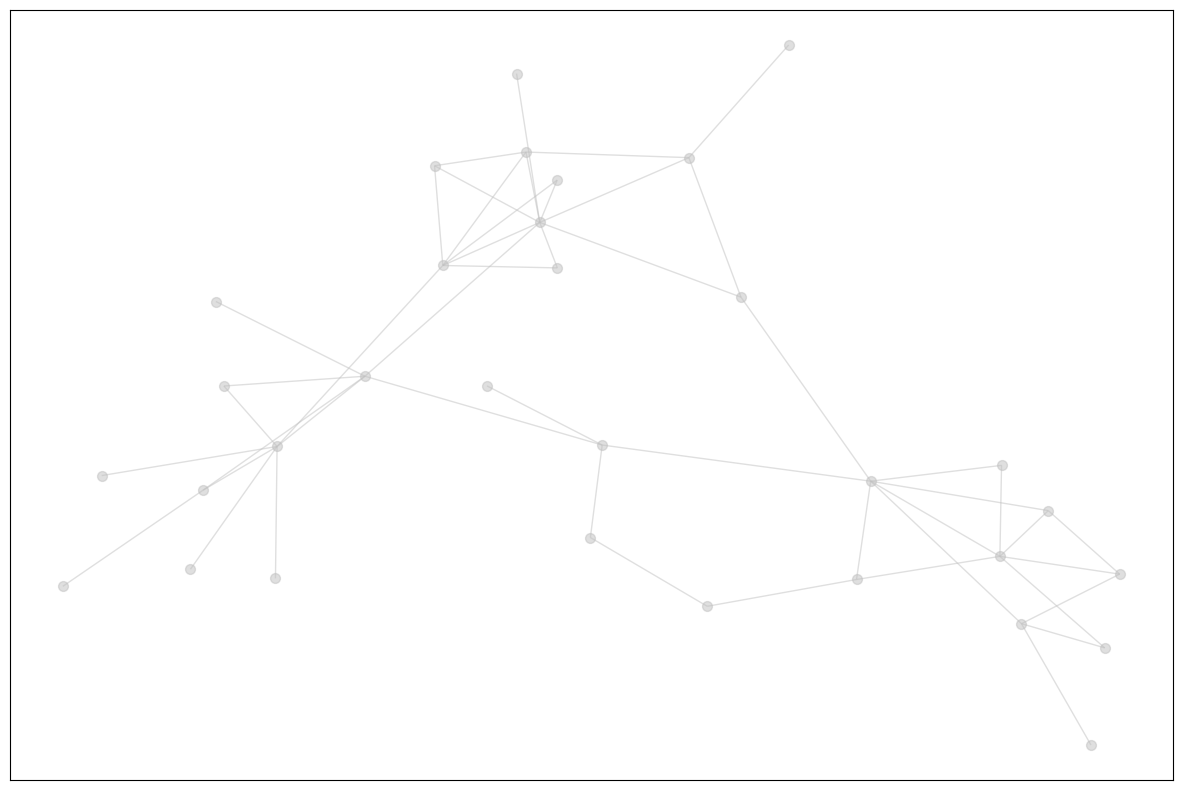

In [25]:
# Draw network
nx.draw_networkx(graph, pos=pos, node_size=50, node_color="silver", edge_color="silver", alpha=0.5, with_labels=False)
plt.show()

# Community Detection Algorithms

## Greedy Modularity communities

### Network

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Community Detection using greedy_modularity_communities Algorithm
start_time = datetime.now()
greedy_communities = sorted(nxcom.greedy_modularity_communities(graph), key=len, reverse=True)
end_time = datetime.now()

In [0]:
# Set node communities
set_node_community(graph, greedy_communities)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [30]:
# Communities Descriptions
print(f"The network has {len(greedy_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")

for i,c in enumerate(greedy_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Time taken by algorithm 0:00:00.003963

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			 0.356 		 1.000
2 		9 		14 		 3			 0.389 		 0.875
3 		9 		10 		 3			 0.278 		 0.875
4 		4 		3 		 3			 0.500 		 1.333


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

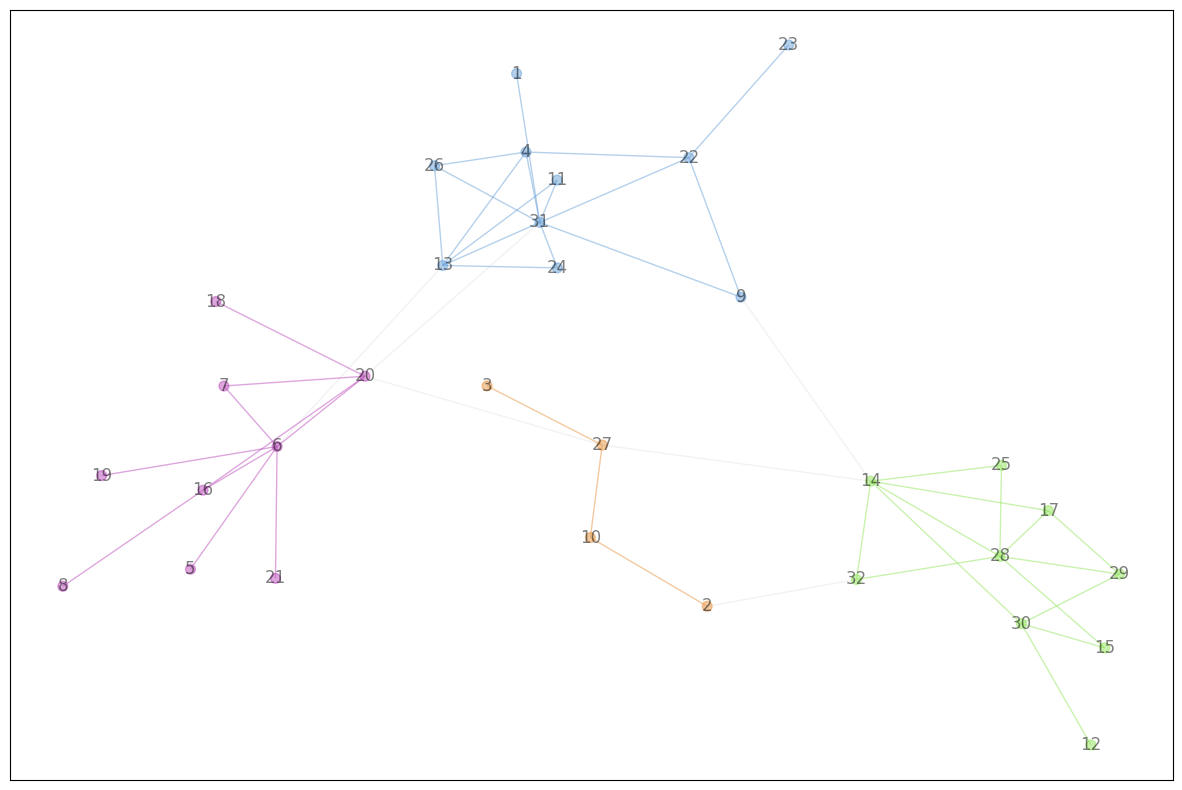

In [33]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [34]:
old_permanence, old_permanence_list = calculatePermanence(graph)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 2120.11it/s]


Permanence Value  0.2628224206349207


In [35]:
greedy_communities[0]

frozenset({'1', '11', '13', '22', '23', '24', '26', '31', '4', '9'})

In [36]:
old_safeness, old_safeness_list = calculateSafenessScore(graph, greedy_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 3196.50it/s]


Safeness Score  0.36173115079365087


### Pemanence Updation

In [0]:
graph1 = nx.parse_edgelist(edge_data, nodetype = str)
set_node_community(graph1, greedy_communities)

In [38]:
new_permanence = max_permanence(graph1)
print("\nNew Permanence Value ", new_permanence)

100%|██████████| 32/32 [00:00<00:00, 487.04it/s]


-0.645064484126984


100%|██████████| 32/32 [00:00<00:00, 583.13it/s]


-0.7167162698412698


100%|██████████| 32/32 [00:00<00:00, 564.83it/s]


-0.7167162698412698

New Permanence Value  -0.7167162698412698


In [0]:
new_greedy_communities = getCommunities(graph1,len(greedy_communities))

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph1)

In [41]:
new_safeness, new_safeness_list = calculateSafenessScore(graph1, new_greedy_communities)
print("\nNew Safeness Score ", new_safeness)

100%|██████████| 32/32 [00:00<00:00, 3878.34it/s]


New Safeness Score  0.44595734126984116


In [42]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  -0.9795386904761905
Safeness Gain 0.08422619047619029


In [43]:
# Communities Descriptions
print(f"The network has {len(greedy_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")

sizes = getCommunitySize(graph1,len(greedy_communities))
for i,c in enumerate(greedy_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{sizes[i]}\t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Time taken by algorithm 0:00:00.003963

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10		7 		 18			 0.156 		 0.778
2 		6		3 		 12			 0.083 		 0.750
3 		9		4 		 18			 0.111 		 1.125
4 		7		5 		 12			 0.833 		 2.333


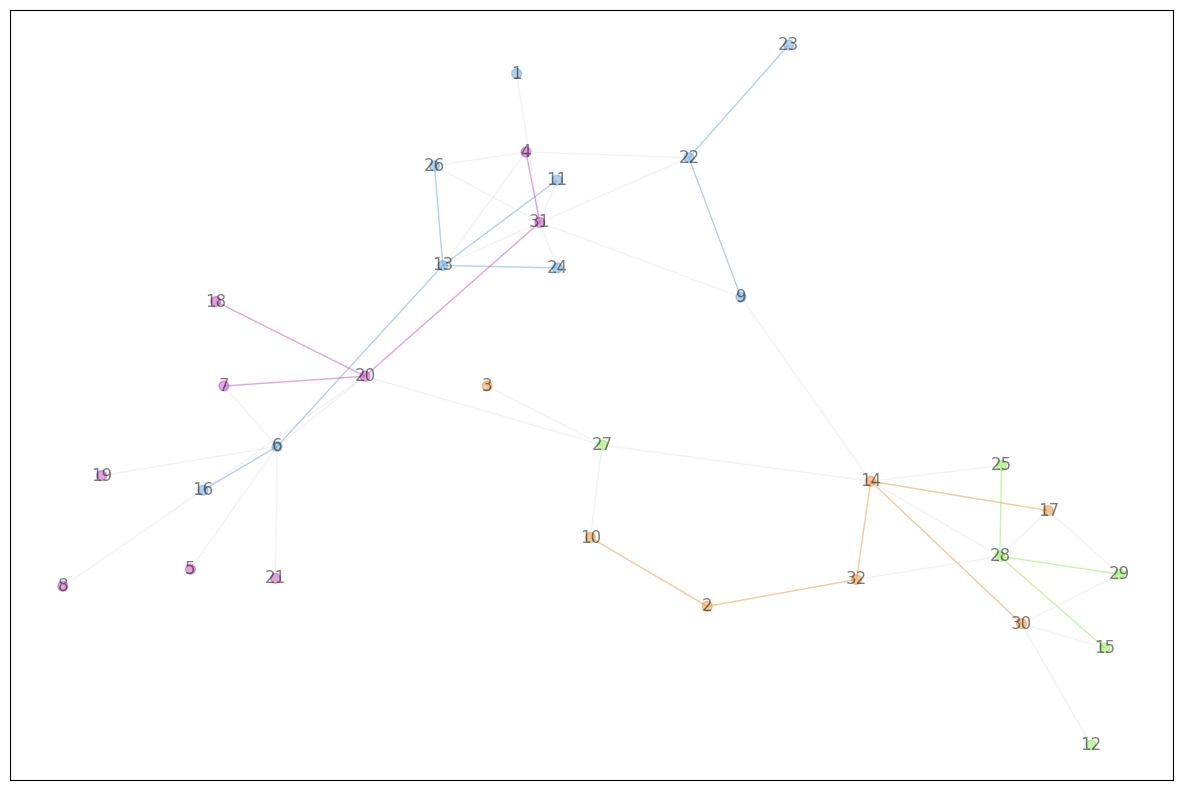

In [44]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] > 0]
# Generate color for each node and egde
node_color = [get_color(graph1.nodes[v]['community']) for v in graph1.nodes]
internal_color = [get_color(graph1.edges[e]['community']) for e in internal]
# Draw Community Graph
nx.draw_networkx(graph1, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph1, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

### Network Rewiring 

In [0]:
graph2 = nx.parse_edgelist(edge_data, nodetype = str)
updated_greedy_communities = sorted(nxcom.greedy_modularity_communities(graph2), key=len, reverse=True)
set_node_community(graph2, updated_greedy_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)

In [46]:
old_permanence, old_permanence_list = calculatePermanence(graph2)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 2402.24it/s]


Permanence Value  0.2628224206349207


In [47]:
old_safeness, old_safeness_list = calculateSafenessScore(graph2, updated_greedy_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 3471.75it/s]


Safeness Score  0.36173115079365087


In [48]:
count = 15
permanence_list = []
safeness_list = []
for p in range(count):
    add_edge(graph2, updated_greedy_communities)
    delete_edge(graph2, updated_greedy_communities)
    updated_greedy_communities = sorted(nxcom.greedy_modularity_communities(graph2), key=len, reverse=True)
    set_node_community(graph2, updated_greedy_communities)
    edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)

    new_permanence, new_permanence_list = calculatePermanence(graph2)
    new_safeness, new_safeness_list = calculateSafenessScore(graph2, updated_greedy_communities)
    permanence_list.append(new_permanence)
    safeness_list.append(new_safeness)
    print("Edge Update",p+1,"[ Permanence Value:", new_permanence,", Safeness Score :", new_safeness,"]\n")
    time.sleep(0.4)

100%|██████████| 32/32 [00:00<00:00, 5482.53it/s]


Edge Update 1 [ Permanence Value: 0.30977182539682546 , Safeness Score : 0.3472842261904763 ]



100%|██████████| 32/32 [00:00<00:00, 4964.41it/s]


Edge Update 2 [ Permanence Value: 0.2915426587301588 , Safeness Score : 0.345374503968254 ]



100%|██████████| 32/32 [00:00<00:00, 6161.58it/s]


Edge Update 3 [ Permanence Value: 0.2748015873015874 , Safeness Score : 0.356609623015873 ]



100%|██████████| 32/32 [00:00<00:00, 4419.42it/s]


Edge Update 4 [ Permanence Value: 0.28053075396825394 , Safeness Score : 0.36285962301587305 ]



100%|██████████| 32/32 [00:00<00:00, 5604.08it/s]


Edge Update 5 [ Permanence Value: 0.32956349206349206 , Safeness Score : 0.35114087301587305 ]



100%|██████████| 32/32 [00:00<00:00, 4713.03it/s]


Edge Update 6 [ Permanence Value: 0.29771825396825397 , Safeness Score : 0.376827426046176 ]



100%|██████████| 32/32 [00:00<00:00, 5359.49it/s]


Edge Update 7 [ Permanence Value: 0.2181175595238095 , Safeness Score : 0.3483072916666668 ]



100%|██████████| 32/32 [00:00<00:00, 5537.03it/s]


Edge Update 8 [ Permanence Value: 0.2365327380952381 , Safeness Score : 0.3463541666666668 ]



100%|██████████| 32/32 [00:00<00:00, 5550.32it/s]


Edge Update 9 [ Permanence Value: 0.23984375000000005 , Safeness Score : 0.364936755952381 ]



100%|██████████| 32/32 [00:00<00:00, 7730.10it/s]


Edge Update 10 [ Permanence Value: 0.28746279761904764 , Safeness Score : 0.35273437500000004 ]



100%|██████████| 32/32 [00:00<00:00, 5282.91it/s]


Edge Update 11 [ Permanence Value: 0.28738839285714285 , Safeness Score : 0.3490141369047619 ]



100%|██████████| 32/32 [00:00<00:00, 5220.85it/s]


Edge Update 12 [ Permanence Value: 0.28746279761904764 , Safeness Score : 0.35273437500000004 ]



100%|██████████| 32/32 [00:00<00:00, 5521.55it/s]


Edge Update 13 [ Permanence Value: 0.28738839285714285 , Safeness Score : 0.3490141369047619 ]



100%|██████████| 32/32 [00:00<00:00, 5396.34it/s]


Edge Update 14 [ Permanence Value: 0.28746279761904764 , Safeness Score : 0.35273437500000004 ]



100%|██████████| 32/32 [00:00<00:00, 4398.13it/s]


Edge Update 15 [ Permanence Value: 0.28738839285714285 , Safeness Score : 0.3490141369047619 ]



In [49]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  0.024565972222222177
Safeness Gain -0.012717013888888962


In [50]:
print(f"The network has {len(updated_greedy_communities)} communities.\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(updated_greedy_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		9 		14 		 3			 0.389 		 0.875
2 		9 		10 		 3			 0.278 		 0.875
3 		9 		15 		 3			 0.417 		 1.000
4 		5 		4 		 3			 0.400 		 1.500


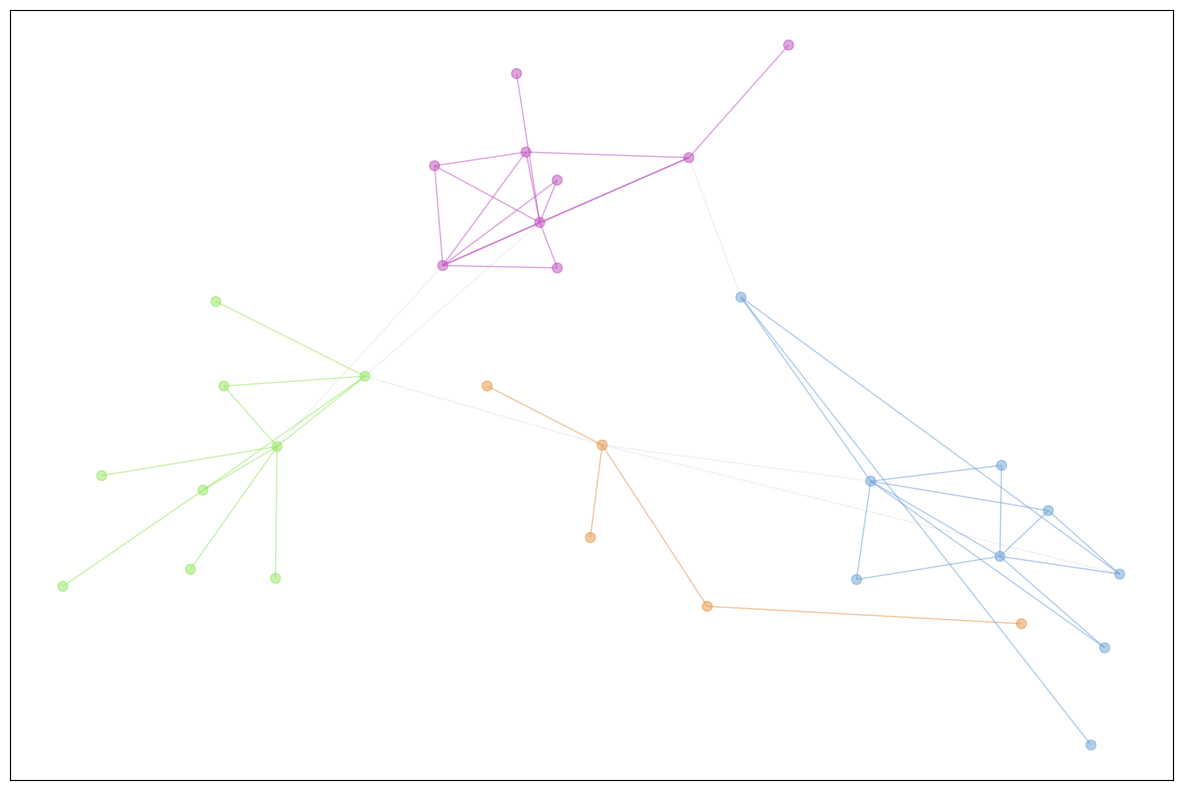

In [51]:
external = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] > 0]
node_color = [get_color(graph2.nodes[v]['community']) for v in graph2.nodes]
internal_color = [get_color(graph2.edges[e]['community']) for e in internal]
nx.draw_networkx(graph2, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph2, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

## Label Propagation Communities

### Network

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Community Detection using label_propagation_communities Algorithm
start_time = datetime.now()
label_communities = sorted(nxcom.label_propagation_communities(graph), key=len, reverse=True)
end_time = datetime.now()

In [0]:
# Set node communities
set_node_community(graph, label_communities)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [56]:
# Communities Descriptions
print(f"The network has {len(label_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(label_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Time taken by algorithm 0:00:00.003324

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			0.356 		 1.000
2 		10 		15 		 3			0.333 		 0.778
3 		9 		10 		 3			0.278 		 0.875
4 		3 		2 		 3			0.667 		 2.000


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

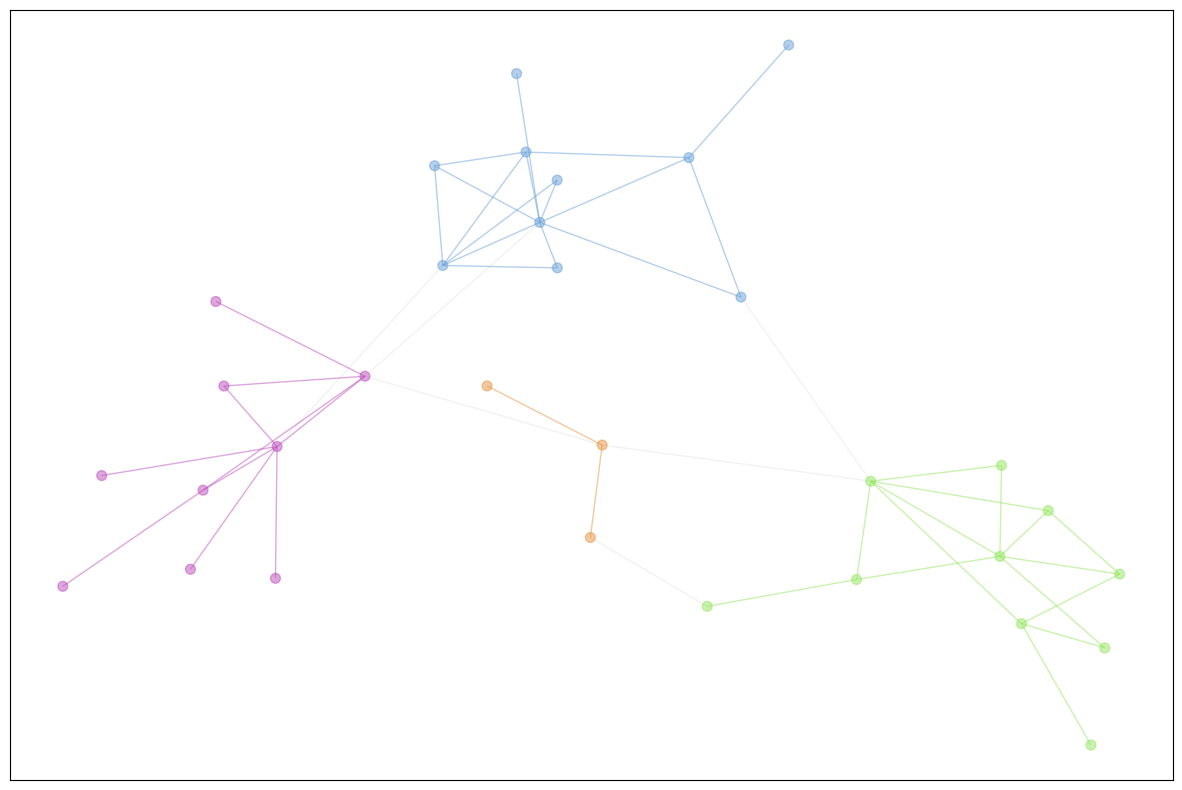

In [59]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

In [60]:
old_permanence, old_permanence_list = calculatePermanence(graph)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1246.18it/s]


Permanence Value  0.23678075396825396


In [61]:
old_safeness, old_safeness_list = calculateSafenessScore(graph, label_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 3671.77it/s]


Safeness Score  0.36693948412698424


### Pemanence Updation

In [0]:
graph1 = nx.parse_edgelist(edge_data, nodetype = str)
set_node_community(graph1, label_communities)

In [63]:
new_permanence = max_permanence(graph1)
print("\nNew Permanence Value ", new_permanence)

100%|██████████| 32/32 [00:00<00:00, 459.59it/s]


-0.6073040674603174


100%|██████████| 32/32 [00:00<00:00, 550.57it/s]


-0.6724454365079365


100%|██████████| 32/32 [00:00<00:00, 578.00it/s]


-0.6724454365079365

New Permanence Value  -0.6724454365079365


In [0]:
new_label_communities = getCommunities(graph1,len(label_communities))

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph1)

In [66]:
new_safeness, new_safeness_list = calculateSafenessScore(graph1, new_label_communities)
print("\nNew Safeness Score ", new_safeness)

100%|██████████| 32/32 [00:00<00:00, 5456.67it/s]


New Safeness Score  0.46757192460317454


In [67]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  -0.9092261904761905
Safeness Gain 0.1006324404761903


In [68]:
# Communities Descriptions
print(f"The network has {len(label_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")

sizes = getCommunitySize(graph1,len(label_communities))
for i,c in enumerate(label_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{sizes[i]}\t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Time taken by algorithm 0:00:00.003324

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10		7 		 18			 0.156 		 0.778
2 		7		5 		 9			 0.111 		 0.667
3 		9		4 		 18			 0.111 		 1.125
4 		6		5 		 11			 1.667 		 3.500


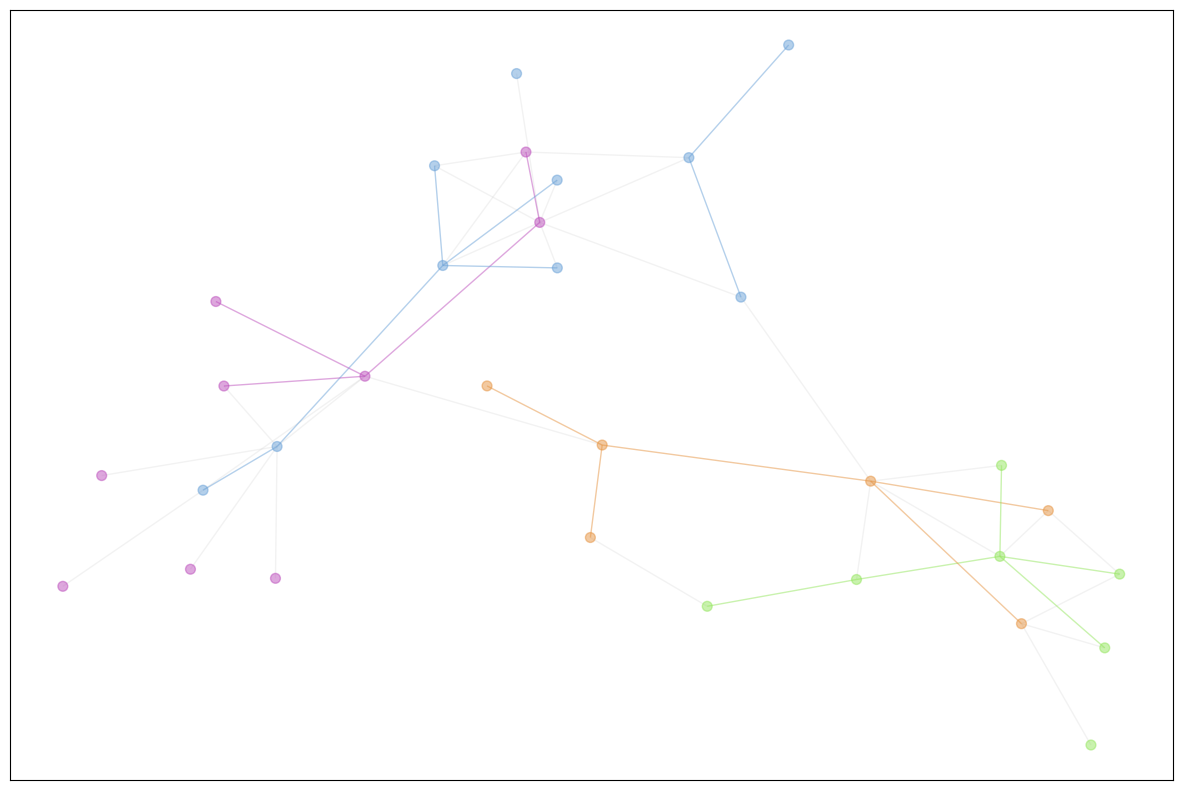

In [69]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] > 0]
# Generate color for each node and egde
node_color = [get_color(graph1.nodes[v]['community']) for v in graph1.nodes]
internal_color = [get_color(graph1.edges[e]['community']) for e in internal]
# Draw Community Graph
nx.draw_networkx(graph1, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph1, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

### Network Rewiring 

In [0]:
graph2 = nx.parse_edgelist(edge_data, nodetype = str)
updated_label_communities = sorted(nxcom.label_propagation_communities(graph2), key=len, reverse=True)
set_node_community(graph2, updated_label_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)

In [71]:
old_permanence, old_permanence_list = calculatePermanence(graph2)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 2032.00it/s]


Permanence Value  0.23678075396825396


In [72]:
old_safeness, old_safeness_list = calculateSafenessScore(graph2, updated_label_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 2546.49it/s]


Safeness Score  0.36693948412698424


In [73]:
count = 15
permanence_list = []
safeness_list = []
for p in range(count):
    add_edge(graph2, updated_label_communities)
    delete_edge(graph2, updated_label_communities)
    updated_label_communities = sorted(nxcom.label_propagation_communities(graph2), key=len, reverse=True)
    set_node_community(graph2, updated_label_communities)
    edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)
    
    new_permanence, new_permanence_list = calculatePermanence(graph2)
    new_safeness, new_safeness_list = calculateSafenessScore(graph2, updated_label_communities)
    permanence_list.append(new_permanence)
    safeness_list.append(new_safeness)
    print("Edge Update",p+1,"[ Permanence Value:", new_permanence,", Safeness Score :", new_safeness,"]\n")
    time.sleep(0.4)

100%|██████████| 32/32 [00:00<00:00, 5874.89it/s]


Edge Update 1 [ Permanence Value: 0.268030753968254 , Safeness Score : 0.3591269841269842 ]



100%|██████████| 32/32 [00:00<00:00, 4414.77it/s]


Edge Update 2 [ Permanence Value: 0.28373015873015883 , Safeness Score : 0.35231894841269845 ]



100%|██████████| 32/32 [00:00<00:00, 5156.27it/s]


Edge Update 3 [ Permanence Value: 0.2889384920634921 , Safeness Score : 0.3472842261904762 ]



100%|██████████| 32/32 [00:00<00:00, 4464.40it/s]


Edge Update 4 [ Permanence Value: 0.290029761904762 , Safeness Score : 0.3496279761904762 ]



100%|██████████| 32/32 [00:00<00:00, 4857.15it/s]


Edge Update 5 [ Permanence Value: 0.2844742063492064 , Safeness Score : 0.34951636904761907 ]



100%|██████████| 32/32 [00:00<00:00, 3761.60it/s]


Edge Update 6 [ Permanence Value: 0.290029761904762 , Safeness Score : 0.3496279761904762 ]



100%|██████████| 32/32 [00:00<00:00, 5357.78it/s]


Edge Update 7 [ Permanence Value: 0.2844742063492064 , Safeness Score : 0.34951636904761907 ]



100%|██████████| 32/32 [00:00<00:00, 4575.50it/s]


Edge Update 8 [ Permanence Value: 0.290029761904762 , Safeness Score : 0.3496279761904762 ]



100%|██████████| 32/32 [00:00<00:00, 5497.35it/s]


Edge Update 9 [ Permanence Value: 0.2844742063492064 , Safeness Score : 0.34951636904761907 ]



100%|██████████| 32/32 [00:00<00:00, 4201.26it/s]


Edge Update 10 [ Permanence Value: 0.290029761904762 , Safeness Score : 0.3496279761904762 ]



100%|██████████| 32/32 [00:00<00:00, 4848.56it/s]


Edge Update 11 [ Permanence Value: 0.2844742063492064 , Safeness Score : 0.34951636904761907 ]



100%|██████████| 32/32 [00:00<00:00, 4697.36it/s]


Edge Update 12 [ Permanence Value: 0.290029761904762 , Safeness Score : 0.3496279761904762 ]



100%|██████████| 32/32 [00:00<00:00, 4772.69it/s]


Edge Update 13 [ Permanence Value: 0.2844742063492064 , Safeness Score : 0.34951636904761907 ]



100%|██████████| 32/32 [00:00<00:00, 7179.72it/s]


Edge Update 14 [ Permanence Value: 0.290029761904762 , Safeness Score : 0.3496279761904762 ]



100%|██████████| 32/32 [00:00<00:00, 4732.98it/s]


Edge Update 15 [ Permanence Value: 0.2844742063492064 , Safeness Score : 0.34951636904761907 ]



In [74]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  0.047693452380952434
Safeness Gain -0.01742311507936517


In [75]:
print(f"The network has {len(updated_label_communities)} communities.\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(updated_label_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			 0.356 		 1.000
2 		10 		16 		 2			 0.356 		 0.778
3 		9 		10 		 3			 0.278 		 0.875
4 		3 		2 		 2			 0.667 		 2.000


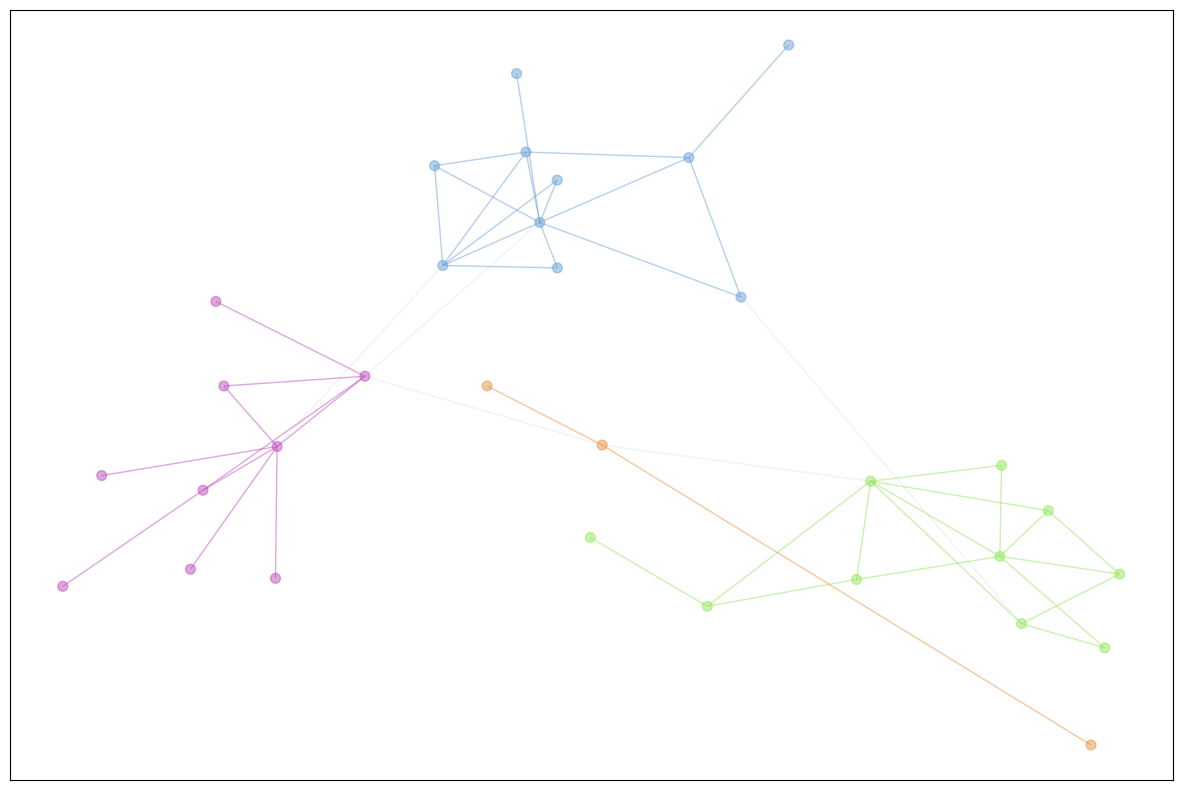

In [76]:
external = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] > 0]
node_color = [get_color(graph2.nodes[v]['community']) for v in graph2.nodes]
internal_color = [get_color(graph2.edges[e]['community']) for e in internal]
nx.draw_networkx(graph2, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph2, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

## Girvan Newman

### Network

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Community Detection using girvan_newman Algorithm
start_time = datetime.now()
communities_generator = girvan_newman(graph)
next(communities_generator)
girvan_communities = next(communities_generator)
end_time = datetime.now()

In [0]:
# Set node communities
set_node_community(graph, girvan_communities)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [81]:
# Communities Descriptions
print(f"The network has {len(girvan_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(girvan_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 3 communities.

Time taken by algorithm 0:00:00.016993

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			0.356 		 1.000
2 		13 		19 		 2			0.244 		 0.583
3 		9 		10 		 3			0.278 		 0.875


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

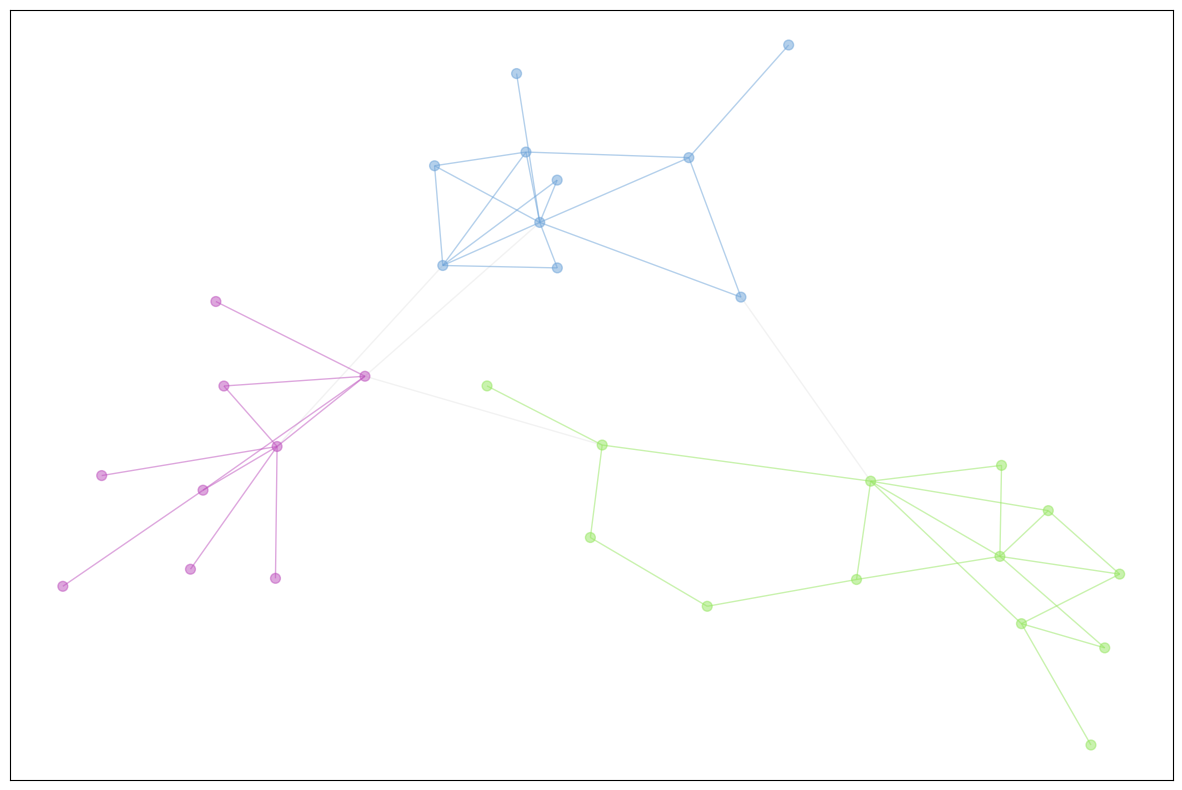

In [84]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

In [85]:
old_permanence, old_permanence_list = calculatePermanence(graph)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1258.72it/s]


Permanence Value  0.2771825396825397


In [86]:
old_safeness, old_safeness_list = calculateSafenessScore(graph, girvan_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 3581.14it/s]


Safeness Score  0.37903025793650796


### Pemanence Updation

In [0]:
graph1 = nx.parse_edgelist(edge_data, nodetype = str)
set_node_community(graph1, girvan_communities)

In [88]:
new_permanence = max_permanence(graph1)
print("\nNew Permanence Value ", new_permanence)

100%|██████████| 32/32 [00:00<00:00, 519.11it/s]


-0.568390376984127


100%|██████████| 32/32 [00:00<00:00, 564.35it/s]


-0.6670510912698412


100%|██████████| 32/32 [00:00<00:00, 568.17it/s]


-0.7295510912698413


100%|██████████| 32/32 [00:00<00:00, 551.68it/s]


-0.7295510912698413

New Permanence Value  -0.7295510912698413


In [0]:
new_girvan_communities = getCommunities(graph1,len(girvan_communities))

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph1)

In [91]:
new_safeness, new_safeness_list = calculateSafenessScore(graph1, new_girvan_communities)
print("\nNew Safeness Score ", new_safeness)

100%|██████████| 32/32 [00:00<00:00, 3668.86it/s]


New Safeness Score  0.4189608134920634


In [92]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  -1.006733630952381
Safeness Gain 0.039930555555555414


In [93]:
# Communities Descriptions
print(f"The network has {len(girvan_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")

sizes = getCommunitySize(graph1,len(girvan_communities))
for i,c in enumerate(girvan_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{sizes[i]}\t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 3 communities.

Time taken by algorithm 0:00:00.016993

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		15		12 		 29			 0.267 		 0.778
2 		8		4 		 11			 0.051 		 0.500
3 		9		4 		 18			 0.111 		 1.125


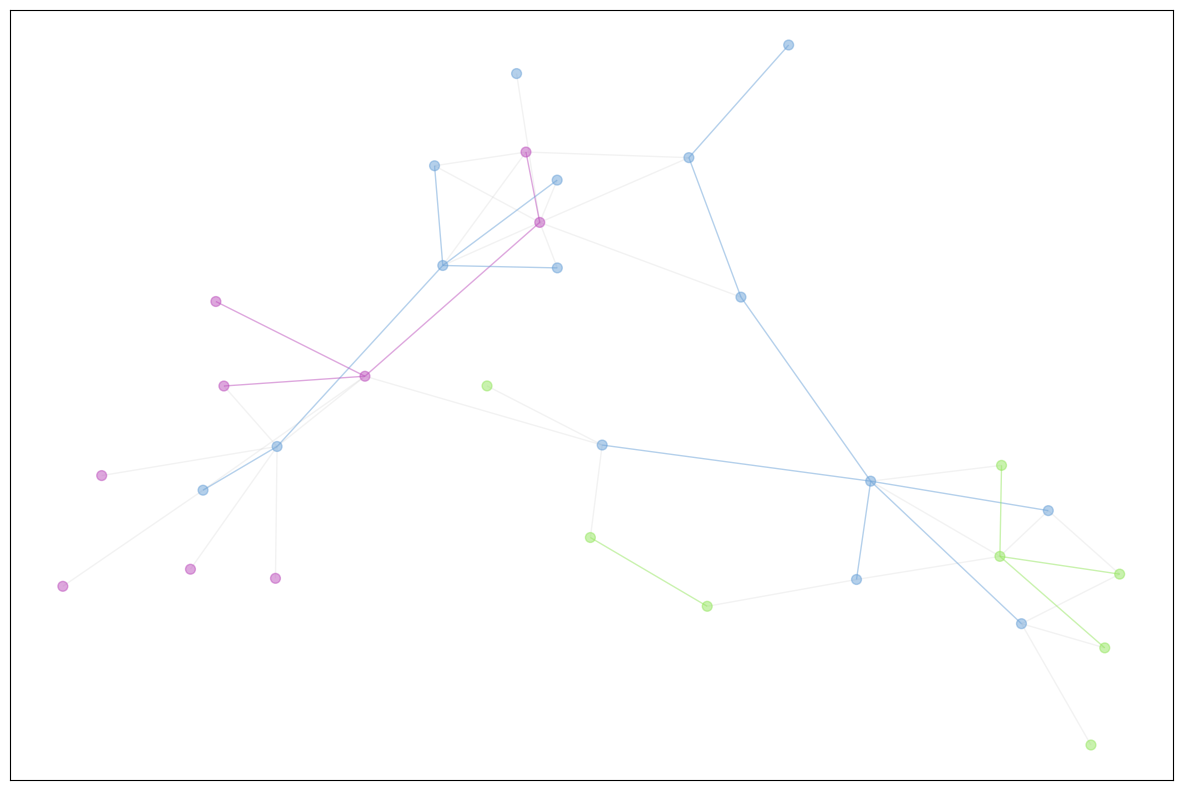

In [94]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] > 0]
# Generate color for each node and egde
node_color = [get_color(graph1.nodes[v]['community']) for v in graph1.nodes]
internal_color = [get_color(graph1.edges[e]['community']) for e in internal]
# Draw Community Graph
nx.draw_networkx(graph1, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph1, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

### Network Rewiring 

In [0]:
graph2 = nx.parse_edgelist(edge_data, nodetype = str)
communities_generator = girvan_newman(graph2)
next(communities_generator)
updated_girvan_communities = next(communities_generator)
set_node_community(graph2, updated_girvan_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)

In [96]:
old_permanence, old_permanence_list = calculatePermanence(graph2)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1551.65it/s]


Permanence Value  0.2771825396825397


In [97]:
old_safeness, old_safeness_list = calculateSafenessScore(graph2, updated_girvan_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 4358.57it/s]


Safeness Score  0.37903025793650796


In [98]:
count = 15
permanence_list = []
safeness_list = []
for p in range(count):
    add_edge(graph2, updated_girvan_communities)
    delete_edge(graph2, updated_girvan_communities)
    communities_generator = girvan_newman(graph2)
    next(communities_generator)
    updated_girvan_communities = next(communities_generator)
    set_node_community(graph2, updated_girvan_communities)
    edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)
    
    new_permanence, new_permanence_list = calculatePermanence(graph2)
    new_safeness, new_safeness_list = calculateSafenessScore(graph2, updated_girvan_communities)
    permanence_list.append(new_permanence)
    safeness_list.append(new_safeness)
    print("Edge Update",p+1,"[ Permanence Value:", new_permanence,", Safeness Score :", new_safeness,"]\n")
    time.sleep(0.4)

100%|██████████| 32/32 [00:00<00:00, 4617.53it/s]


Edge Update 1 [ Permanence Value: 0.2809895833333334 , Safeness Score : 0.38000658195970705 ]



100%|██████████| 32/32 [00:00<00:00, 6840.86it/s]


Edge Update 2 [ Permanence Value: 0.2771825396825397 , Safeness Score : 0.37903025793650796 ]



100%|██████████| 32/32 [00:00<00:00, 5859.25it/s]


Edge Update 3 [ Permanence Value: 0.2809895833333334 , Safeness Score : 0.38000658195970705 ]



100%|██████████| 32/32 [00:00<00:00, 4572.07it/s]


Edge Update 4 [ Permanence Value: 0.2771825396825397 , Safeness Score : 0.37903025793650796 ]



100%|██████████| 32/32 [00:00<00:00, 4148.41it/s]


Edge Update 5 [ Permanence Value: 0.2809895833333334 , Safeness Score : 0.38000658195970705 ]



100%|██████████| 32/32 [00:00<00:00, 5002.52it/s]


Edge Update 6 [ Permanence Value: 0.2771825396825397 , Safeness Score : 0.37903025793650796 ]



100%|██████████| 32/32 [00:00<00:00, 4378.62it/s]


Edge Update 7 [ Permanence Value: 0.2809895833333334 , Safeness Score : 0.38000658195970705 ]



100%|██████████| 32/32 [00:00<00:00, 5141.26it/s]


Edge Update 8 [ Permanence Value: 0.2771825396825397 , Safeness Score : 0.37903025793650796 ]



100%|██████████| 32/32 [00:00<00:00, 4184.37it/s]


Edge Update 9 [ Permanence Value: 0.2809895833333334 , Safeness Score : 0.38000658195970705 ]



100%|██████████| 32/32 [00:00<00:00, 6032.26it/s]


Edge Update 10 [ Permanence Value: 0.2771825396825397 , Safeness Score : 0.37903025793650796 ]



100%|██████████| 32/32 [00:00<00:00, 4804.30it/s]


Edge Update 11 [ Permanence Value: 0.2809895833333334 , Safeness Score : 0.38000658195970705 ]



100%|██████████| 32/32 [00:00<00:00, 3951.07it/s]


Edge Update 12 [ Permanence Value: 0.2771825396825397 , Safeness Score : 0.37903025793650796 ]



100%|██████████| 32/32 [00:00<00:00, 5797.49it/s]


Edge Update 13 [ Permanence Value: 0.2809895833333334 , Safeness Score : 0.38000658195970705 ]



100%|██████████| 32/32 [00:00<00:00, 5834.29it/s]


Edge Update 14 [ Permanence Value: 0.2771825396825397 , Safeness Score : 0.37903025793650796 ]



100%|██████████| 32/32 [00:00<00:00, 5651.27it/s]


Edge Update 15 [ Permanence Value: 0.2809895833333334 , Safeness Score : 0.38000658195970705 ]



In [99]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  0.0038070436507937067
Safeness Gain 0.0009763240231990822


In [100]:
print(f"The network has {len(updated_girvan_communities)} communities.\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(updated_girvan_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 3 communities.

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		9 		14 		 3			 0.389 		 1.000
2 		14 		21 		 2			 0.231 		 0.538
3 		9 		10 		 3			 0.278 		 0.875


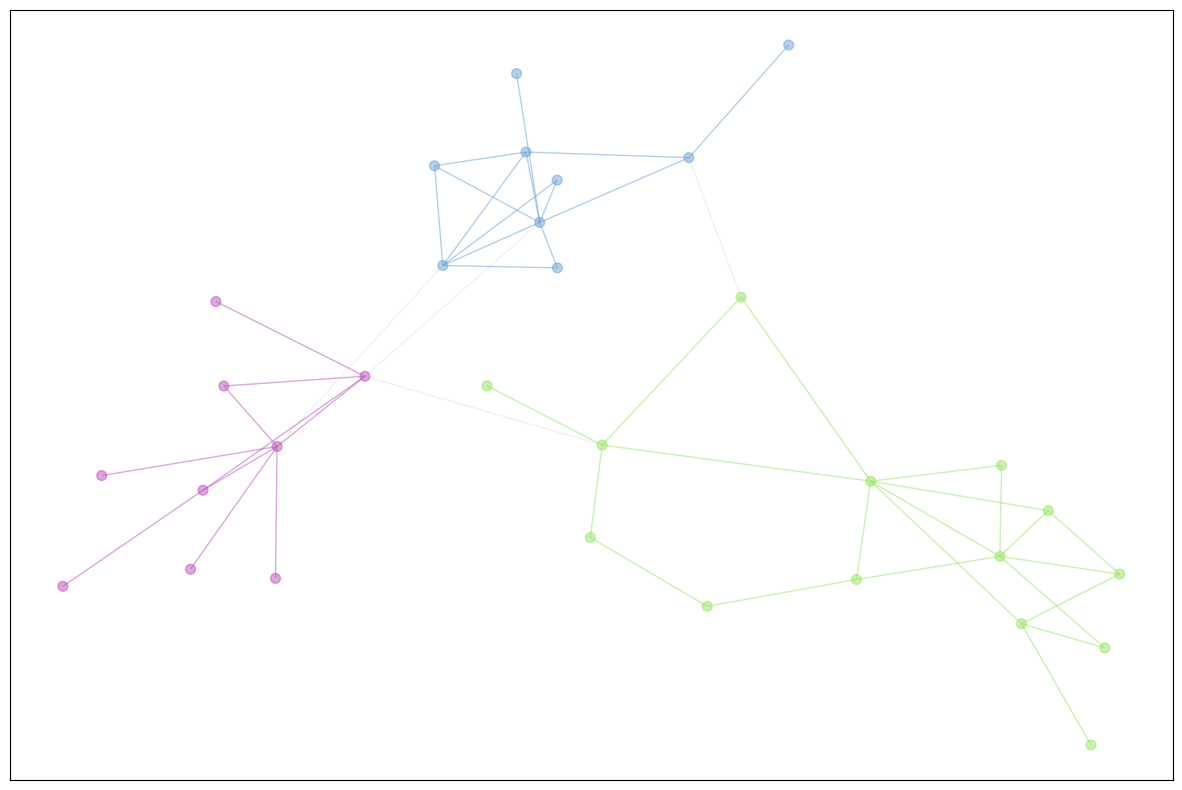

In [101]:
external = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] > 0]
node_color = [get_color(graph2.nodes[v]['community']) for v in graph2.nodes]
internal_color = [get_color(graph2.edges[e]['community']) for e in internal]
nx.draw_networkx(graph2, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph2, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

## Asyn Lpa Communities

### Network

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Community Detection using asyn_lpa_communities Algorithm
start_time = datetime.now()
lpa_communities = sorted(nxcom.asyn_lpa_communities(graph), key=len, reverse=True)
end_time = datetime.now()

In [0]:
# Set node communities
set_node_community(graph, lpa_communities)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [106]:
# Communities Descriptions
print(f"The network has {len(lpa_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(lpa_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 5 communities.

Time taken by algorithm 0:00:00.002978

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			0.356 		 1.000
2 		9 		10 		 3			0.278 		 0.875
3 		6 		9 		 6			0.600 		 1.400
4 		4 		3 		 3			0.500 		 1.333
5 		3 		2 		 3			0.667 		 2.000


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

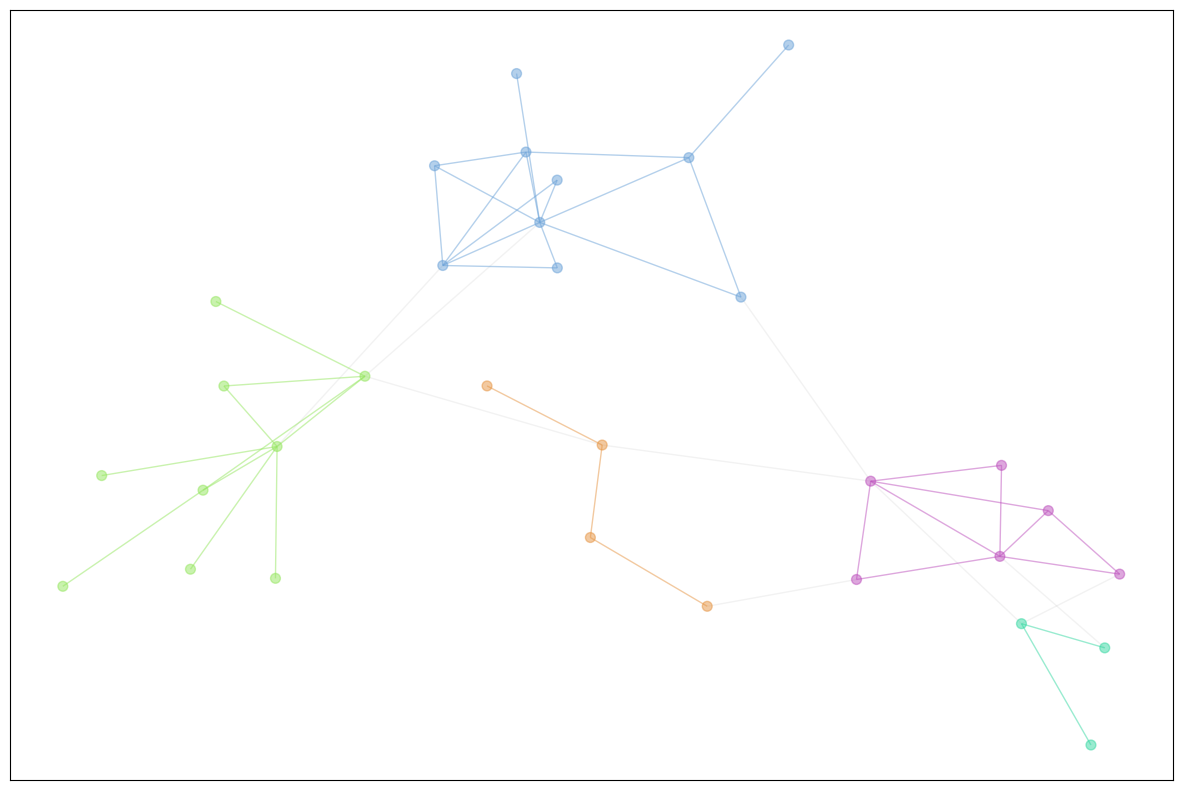

In [109]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

In [110]:
old_permanence, old_permanence_list = calculatePermanence(graph)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1809.01it/s]


Permanence Value  0.23492063492063495


In [111]:
old_safeness, old_safeness_list = calculateSafenessScore(graph, lpa_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 3825.61it/s]


Safeness Score  0.3545882936507937


### Pemanence Updation

In [0]:
graph1 = nx.parse_edgelist(edge_data, nodetype = str)
set_node_community(graph1, lpa_communities)

In [113]:
new_permanence = max_permanence(graph1)
print("\nNew Permanence Value ", new_permanence)

100%|██████████| 32/32 [00:00<00:00, 526.46it/s]


-0.6609002976190476


100%|██████████| 32/32 [00:00<00:00, 581.29it/s]


-0.7327752976190476


100%|██████████| 32/32 [00:00<00:00, 579.70it/s]


-0.7327752976190476

New Permanence Value  -0.7327752976190476


In [0]:
new_lpa_communities = getCommunities(graph1,len(lpa_communities))

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph1)

In [116]:
new_safeness, new_safeness_list = calculateSafenessScore(graph1, new_lpa_communities)
print("\nNew Safeness Score ", new_safeness)

100%|██████████| 32/32 [00:00<00:00, 4067.82it/s]


New Safeness Score  0.44804067460317454


In [117]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  -0.9676959325396826
Safeness Gain 0.09345238095238084


In [118]:
# Communities Descriptions
print(f"The network has {len(lpa_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")

sizes = getCommunitySize(graph1,len(lpa_communities))
for i,c in enumerate(lpa_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{sizes[i]}\t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 5 communities.

Time taken by algorithm 0:00:00.002978

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10		7 		 18			 0.156 		 0.778
2 		9		4 		 18			 0.111 		 1.125
3 		4		2 		 11			 0.133 		 1.200
4 		7		5 		 12			 0.833 		 2.333
5 		2		0 		 3			 0.000 		 1.000


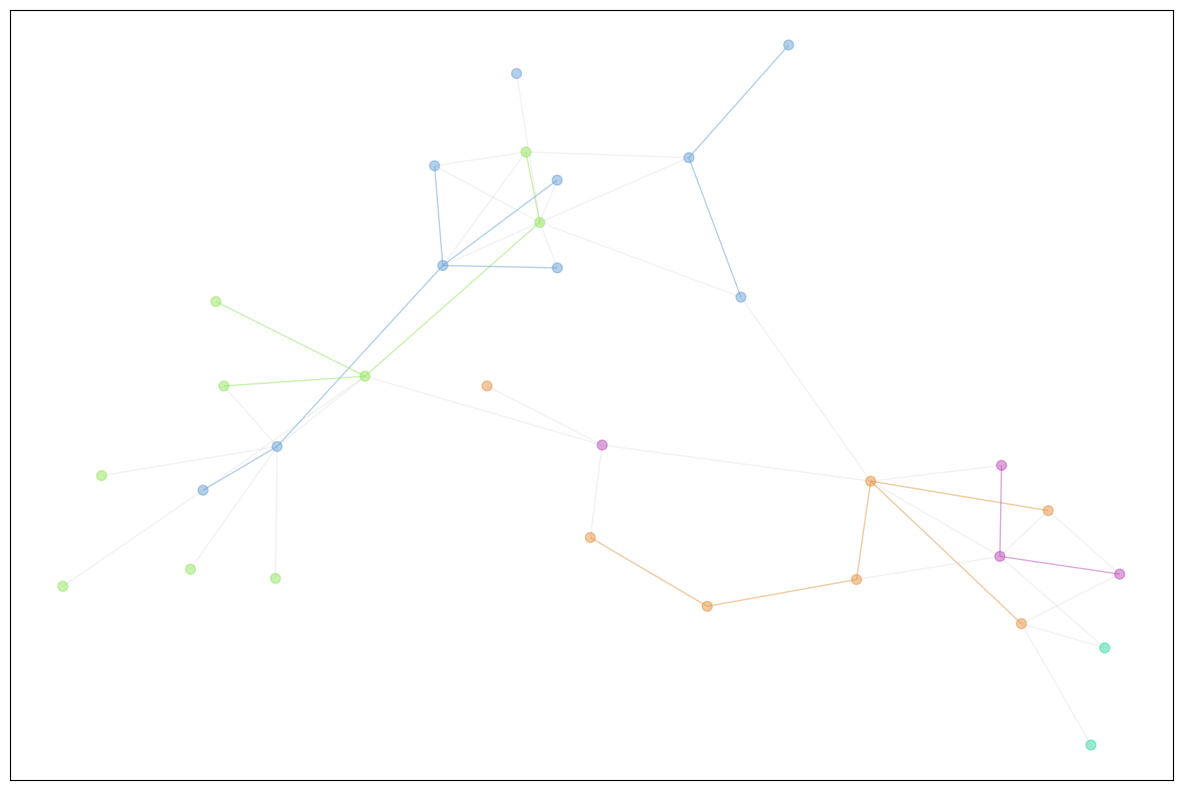

In [119]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] > 0]
# Generate color for each node and egde
node_color = [get_color(graph1.nodes[v]['community']) for v in graph1.nodes]
internal_color = [get_color(graph1.edges[e]['community']) for e in internal]
# Draw Community Graph
nx.draw_networkx(graph1, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph1, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

### Network Rewiring 

In [0]:
graph2 = nx.parse_edgelist(edge_data, nodetype = str)
updated_lpa_communities = sorted(nxcom.asyn_lpa_communities(graph2), key=len, reverse=True)
set_node_community(graph2, updated_lpa_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)

In [121]:
old_permanence, old_permanence_list = calculatePermanence(graph2)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1837.37it/s]


Permanence Value  0.03893849206349206


In [122]:
old_safeness, old_safeness_list = calculateSafenessScore(graph2, updated_lpa_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 4178.24it/s]


Safeness Score  0.38686755952380947


In [123]:
count = 15
permanence_list = []
safeness_list = []
for p in range(count):
    add_edge(graph2, updated_lpa_communities)
    delete_edge(graph2, updated_lpa_communities)
    updated_lpa_communities = sorted(nxcom.asyn_lpa_communities(graph2), key=len, reverse=True)
    set_node_community(graph2, updated_lpa_communities)
    edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)
    
    new_permanence, new_permanence_list = calculatePermanence(graph2)
    new_safeness, new_safeness_list = calculateSafenessScore(graph2, updated_lpa_communities)
    permanence_list.append(new_permanence)
    safeness_list.append(new_safeness)
    print("Edge Update",p+1,"[ Permanence Value:", new_permanence,", Safeness Score :", new_safeness,"]\n")
    time.sleep(0.4)

100%|██████████| 32/32 [00:00<00:00, 11553.56it/s]


Edge Update 1 [ Permanence Value: -0.0061011904761905066 , Safeness Score : 0.2733630952380952 ]



100%|██████████| 32/32 [00:00<00:00, 6564.50it/s]


Edge Update 2 [ Permanence Value: 0.09723462301587299 , Safeness Score : 0.3331163194444445 ]



100%|██████████| 32/32 [00:00<00:00, 5716.74it/s]


Edge Update 3 [ Permanence Value: 0.1673115079365079 , Safeness Score : 0.36043244949494935 ]



100%|██████████| 32/32 [00:00<00:00, 8562.53it/s]


Edge Update 4 [ Permanence Value: 0.12033730158730156 , Safeness Score : 0.31091720779220783 ]



100%|██████████| 32/32 [00:00<00:00, 6511.31it/s]


Edge Update 5 [ Permanence Value: 0.10294312169312167 , Safeness Score : 0.34709821428571436 ]



100%|██████████| 32/32 [00:00<00:00, 4441.21it/s]


Edge Update 6 [ Permanence Value: 0.19841269841269843 , Safeness Score : 0.33437786172161177 ]



100%|██████████| 32/32 [00:00<00:00, 8224.13it/s]


Edge Update 7 [ Permanence Value: 0.18601190476190477 , Safeness Score : 0.3148313492063492 ]



100%|██████████| 32/32 [00:00<00:00, 8172.05it/s]


Edge Update 8 [ Permanence Value: 0.15493551587301588 , Safeness Score : 0.3514756944444445 ]



100%|██████████| 32/32 [00:00<00:00, 9065.09it/s]


Edge Update 9 [ Permanence Value: 0.15570436507936508 , Safeness Score : 0.3131448412698413 ]



100%|██████████| 32/32 [00:00<00:00, 4977.66it/s]


Edge Update 10 [ Permanence Value: 0.21273223304473307 , Safeness Score : 0.3251815025252526 ]



100%|██████████| 32/32 [00:00<00:00, 6505.32it/s]


Edge Update 11 [ Permanence Value: 0.15153769841269843 , Safeness Score : 0.31522817460317465 ]



100%|██████████| 32/32 [00:00<00:00, 4785.63it/s]


Edge Update 12 [ Permanence Value: 0.21273223304473307 , Safeness Score : 0.3251815025252526 ]



100%|██████████| 32/32 [00:00<00:00, 5363.13it/s]


Edge Update 13 [ Permanence Value: 0.17132936507936508 , Safeness Score : 0.3365823412698414 ]



100%|██████████| 32/32 [00:00<00:00, 4473.63it/s]


Edge Update 14 [ Permanence Value: 0.29101957070707074 , Safeness Score : 0.3860006313131313 ]



100%|██████████| 32/32 [00:00<00:00, 9013.35it/s]


Edge Update 15 [ Permanence Value: 0.18191626082251083 , Safeness Score : 0.2780894886363637 ]



In [124]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  0.14297776875901877
Safeness Gain -0.10877807088744579


In [125]:
print(f"The network has {len(updated_lpa_communities)} communities.\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(updated_lpa_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 8 communities.

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		9 		14 		 2			 0.389 		 1.000
2 		9 		15 		 3			 0.417 		 1.375
3 		3 		2 		 3			 0.667 		 2.500
4 		3 		2 		 5			 0.667 		 2.500
5 		2 		1 		 3			 1.000 		 4.000
6 		2 		1 		 2			 1.000 		 3.000
7 		2 		1 		 5			 1.000 		 6.000
8 		2 		1 		 1			 1.000 		 2.000


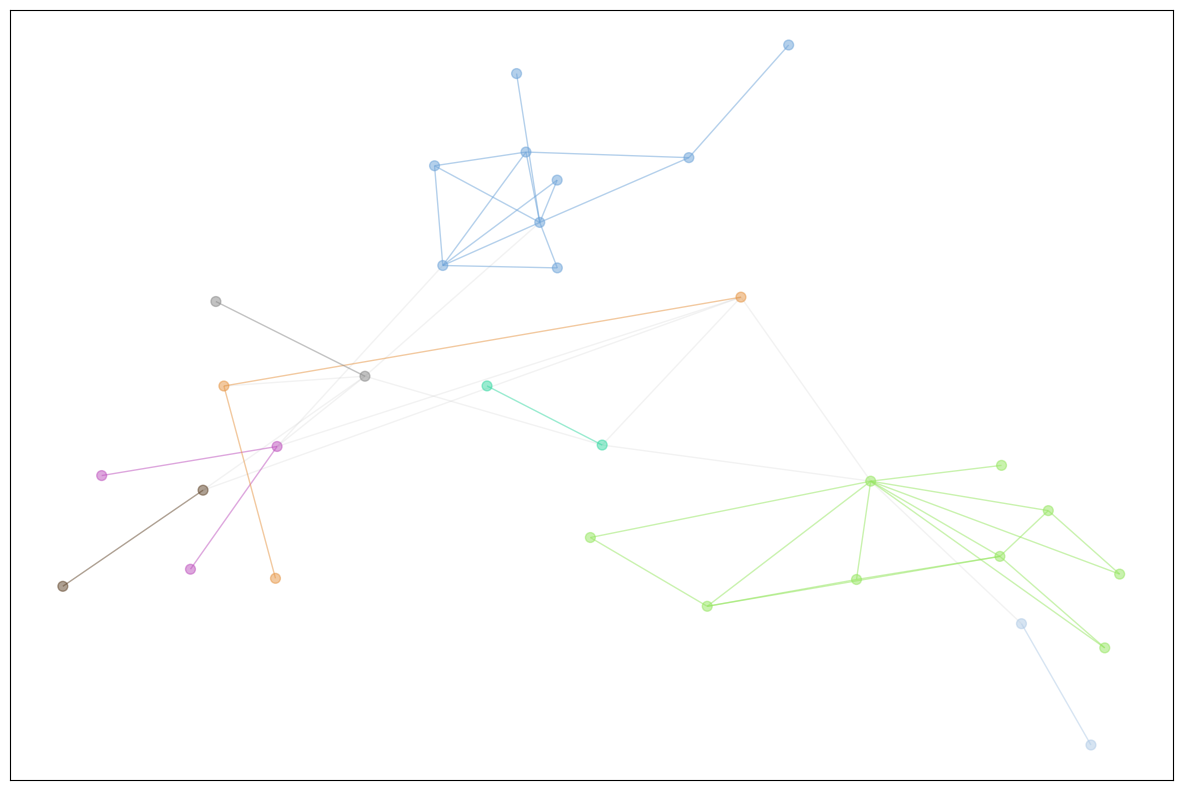

In [126]:
external = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] > 0]
node_color = [get_color(graph2.nodes[v]['community']) for v in graph2.nodes]
internal_color = [get_color(graph2.edges[e]['community']) for e in internal]
nx.draw_networkx(graph2, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph2, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

## Bisection

### Network

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Community Detection using kernighan_lin_bisection Algorithm
start_time = datetime.now()
bisection_communities = sorted(nxcom.kernighan_lin_bisection(graph), key=len, reverse=True)
end_time = datetime.now()

In [0]:
# Set node communities
set_node_community(graph, bisection_communities)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [131]:
# Communities Descriptions
print(f"The network has {len(bisection_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(bisection_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 2 communities.

Time taken by algorithm 0:00:00.016562

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		16 		22 		 7			0.183 		 0.600
2 		16 		20 		 7			0.167 		 0.467


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

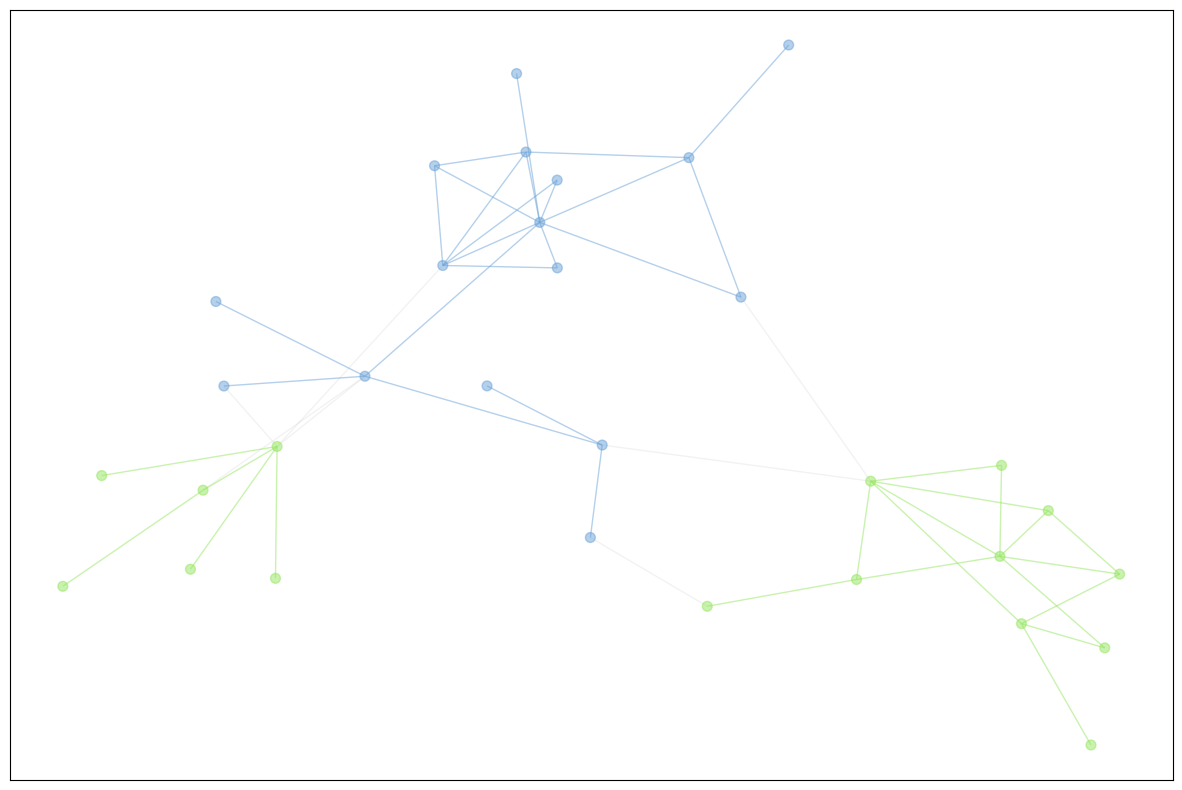

In [134]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

In [135]:
old_permanence, old_permanence_list = calculatePermanence(graph)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1329.64it/s]


Permanence Value  0.12162698412698413


In [136]:
old_safeness, old_safeness_list = calculateSafenessScore(graph, bisection_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 2302.35it/s]


Safeness Score  0.3442336309523809


### Pemanence Updation

In [0]:
graph1 = nx.parse_edgelist(edge_data, nodetype = str)
set_node_community(graph1, bisection_communities)

In [138]:
new_permanence = max_permanence(graph1)
print("\nNew Permanence Value ", new_permanence)

100%|██████████| 32/32 [00:00<00:00, 460.03it/s]


-0.28722718253968255


100%|██████████| 32/32 [00:00<00:00, 521.05it/s]


-0.3714037698412699


100%|██████████| 32/32 [00:00<00:00, 508.88it/s]


-0.3714037698412699

New Permanence Value  -0.3714037698412699


In [0]:
new_bisection_communities = getCommunities(graph1,len(bisection_communities))

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph1)

In [141]:
new_safeness, new_safeness_list = calculateSafenessScore(graph1, new_bisection_communities)
print("\nNew Safeness Score ", new_safeness)

100%|██████████| 32/32 [00:00<00:00, 2737.52it/s]


New Safeness Score  0.46468874007936506


In [142]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  -0.493030753968254
Safeness Gain 0.12045510912698415


In [143]:
# Communities Descriptions
print(f"The network has {len(bisection_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")

sizes = getCommunitySize(graph1,len(bisection_communities))
for i,c in enumerate(bisection_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{sizes[i]}\t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 2 communities.

Time taken by algorithm 0:00:00.016562

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		17		19 		 18			 0.158 		 0.600
2 		15		12 		 18			 0.100 		 0.467


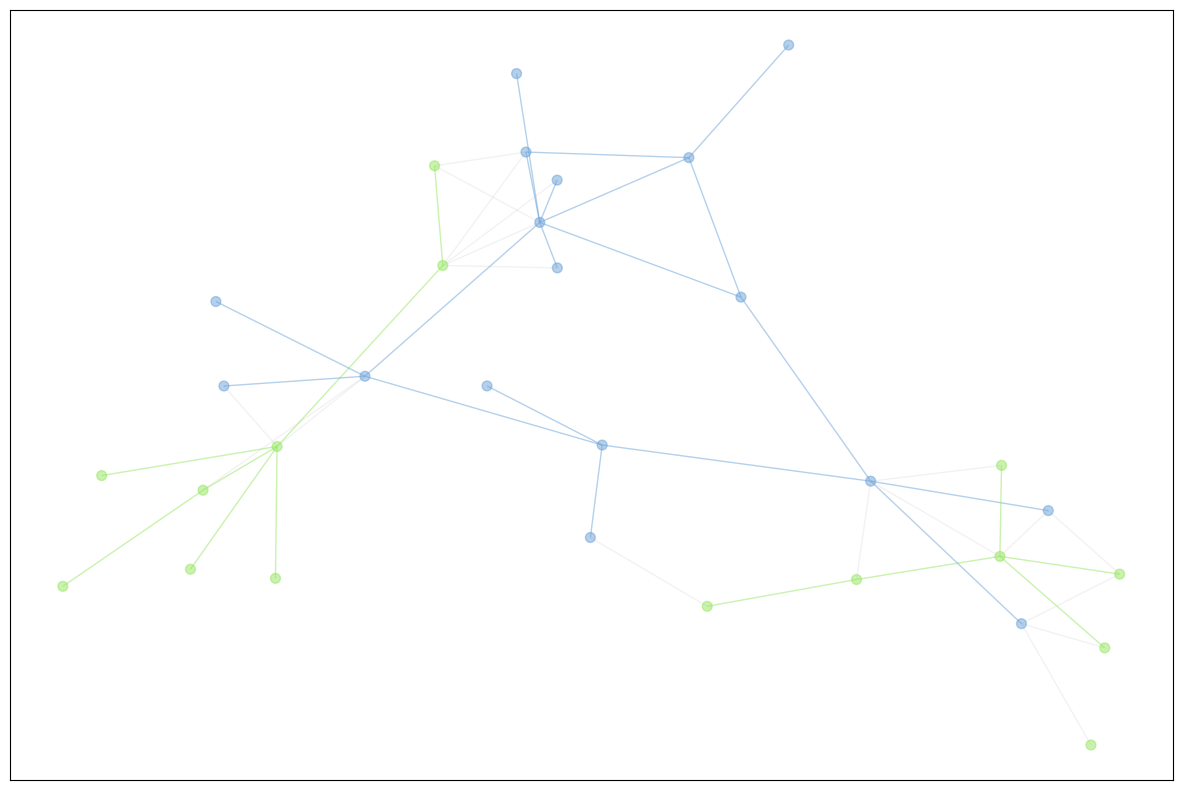

In [144]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] > 0]
# Generate color for each node and egde
node_color = [get_color(graph1.nodes[v]['community']) for v in graph1.nodes]
internal_color = [get_color(graph1.edges[e]['community']) for e in internal]
# Draw Community Graph
nx.draw_networkx(graph1, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph1, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

### Network Rewiring 

In [0]:
graph2 = nx.parse_edgelist(edge_data, nodetype = str)
updated_bisection_communities = sorted(nxcom.kernighan_lin_bisection(graph2), key=len, reverse=True)
set_node_community(graph2, updated_bisection_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)

In [146]:
old_permanence, old_permanence_list = calculatePermanence(graph2)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1889.99it/s]


Permanence Value  0.14905753968253965


In [147]:
old_safeness, old_safeness_list = calculateSafenessScore(graph2, updated_bisection_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 2950.03it/s]


Safeness Score  0.40620039682539694


In [148]:
count = 15
permanence_list = []
safeness_list = []
for p in range(count):
    add_edge(graph2, updated_bisection_communities)
    delete_edge(graph2, updated_bisection_communities)
    updated_bisection_communities = sorted(nxcom.kernighan_lin_bisection(graph2), key=len, reverse=True)
    set_node_community(graph2, updated_bisection_communities)
    edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)
    
    new_permanence, new_permanence_list = calculatePermanence(graph2)
    new_safeness, new_safeness_list = calculateSafenessScore(graph2, updated_bisection_communities)
    permanence_list.append(new_permanence)
    safeness_list.append(new_safeness)
    print("Edge Update",p+1,"[ Permanence Value:", new_permanence,", Safeness Score :", new_safeness,"]\n")
    time.sleep(0.4)

100%|██████████| 32/32 [00:00<00:00, 3853.84it/s]


Edge Update 1 [ Permanence Value: 0.2052455357142857 , Safeness Score : 0.43945312500000017 ]



100%|██████████| 32/32 [00:00<00:00, 5131.24it/s]


Edge Update 2 [ Permanence Value: 0.14720982142857142 , Safeness Score : 0.3910528273809525 ]



100%|██████████| 32/32 [00:00<00:00, 3121.05it/s]


Edge Update 3 [ Permanence Value: 0.1540550595238095 , Safeness Score : 0.42230282738095254 ]



100%|██████████| 32/32 [00:00<00:00, 3324.44it/s]


Edge Update 4 [ Permanence Value: 0.18727678571428572 , Safeness Score : 0.4348214285714287 ]



100%|██████████| 32/32 [00:00<00:00, 3746.17it/s]


Edge Update 5 [ Permanence Value: 0.15379464285714284 , Safeness Score : 0.38493303571428583 ]



100%|██████████| 32/32 [00:00<00:00, 4242.16it/s]


Edge Update 6 [ Permanence Value: 0.12715773809523806 , Safeness Score : 0.3718377976190477 ]



100%|██████████| 32/32 [00:00<00:00, 3599.87it/s]


Edge Update 7 [ Permanence Value: 0.1417782738095238 , Safeness Score : 0.3722842261904763 ]



100%|██████████| 32/32 [00:00<00:00, 5317.45it/s]


Edge Update 8 [ Permanence Value: 0.17306547619047616 , Safeness Score : 0.32752976190476185 ]



100%|██████████| 32/32 [00:00<00:00, 3925.99it/s]


Edge Update 9 [ Permanence Value: 0.1438988095238095 , Safeness Score : 0.32741815476190467 ]



100%|██████████| 32/32 [00:00<00:00, 3772.70it/s]


Edge Update 10 [ Permanence Value: 0.13404017857142853 , Safeness Score : 0.45995163690476204 ]



100%|██████████| 32/32 [00:00<00:00, 2676.33it/s]


Edge Update 11 [ Permanence Value: 0.17462797619047615 , Safeness Score : 0.4447544642857144 ]



100%|██████████| 32/32 [00:00<00:00, 5255.61it/s]


Edge Update 12 [ Permanence Value: 0.1542410714285714 , Safeness Score : 0.34817708333333347 ]



100%|██████████| 32/32 [00:00<00:00, 3793.28it/s]


Edge Update 13 [ Permanence Value: 0.12663690476190476 , Safeness Score : 0.3489583333333333 ]



100%|██████████| 32/32 [00:00<00:00, 3906.45it/s]


Edge Update 14 [ Permanence Value: 0.25691964285714286 , Safeness Score : 0.44006696428571446 ]



100%|██████████| 32/32 [00:00<00:00, 3888.79it/s]


Edge Update 15 [ Permanence Value: 0.14925595238095235 , Safeness Score : 0.35264136904761917 ]



In [149]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  0.0001984126984126977
Safeness Gain -0.05355902777777777


In [150]:
print(f"The network has {len(updated_bisection_communities)} communities.\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(updated_bisection_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 2 communities.

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		16 		19 		 5			 0.158 		 0.400
2 		16 		25 		 5			 0.208 		 0.533


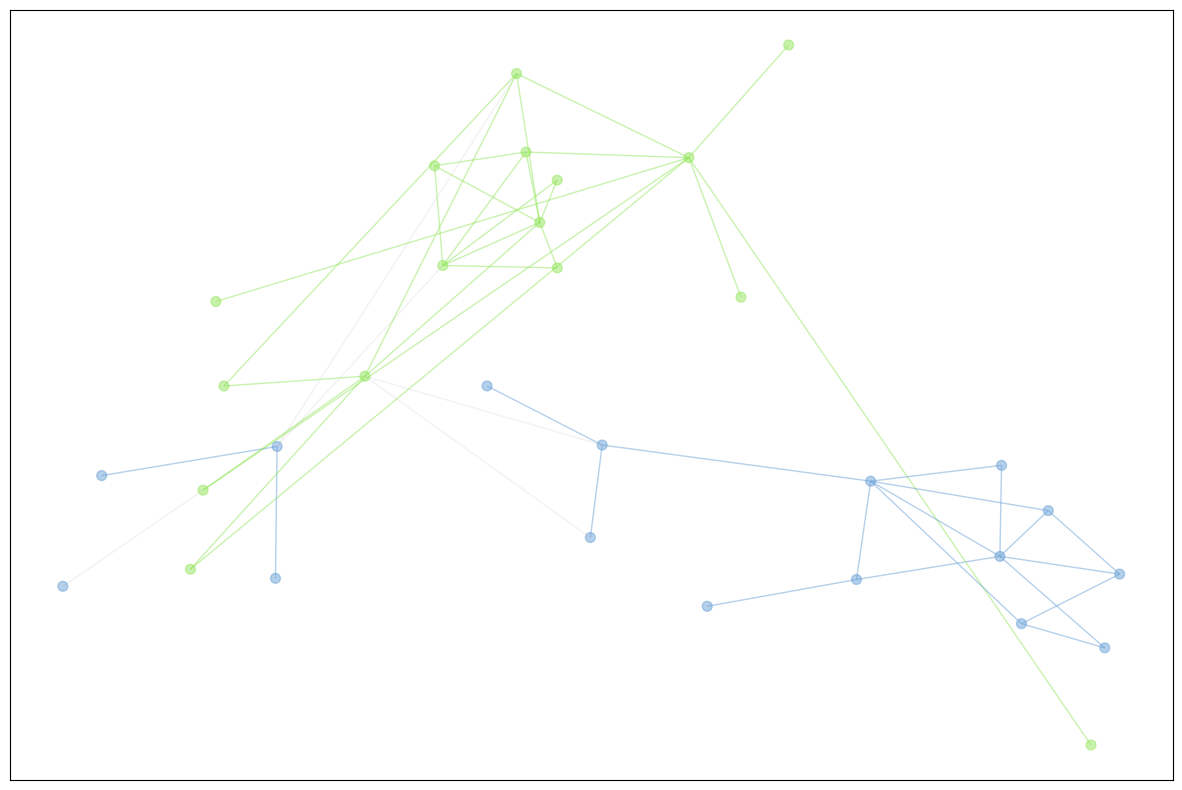

In [151]:
external = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] > 0]
node_color = [get_color(graph2.nodes[v]['community']) for v in graph2.nodes]
internal_color = [get_color(graph2.edges[e]['community']) for e in internal]
nx.draw_networkx(graph2, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph2, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

## k Clique Communities

### Network

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Community Detection using k_clique_communities Algorithm
start_time = datetime.now()
clique_communities = list(k_clique_communities(graph, 2))
end_time = datetime.now()

In [0]:
# Set node communities
set_node_community(graph, clique_communities)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [156]:
# Communities Descriptions
print(f"The network has {len(clique_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(clique_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 1 communities.

Time taken by algorithm 0:00:00.005430

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		32 		49 		 0			0.099 		 0.290


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

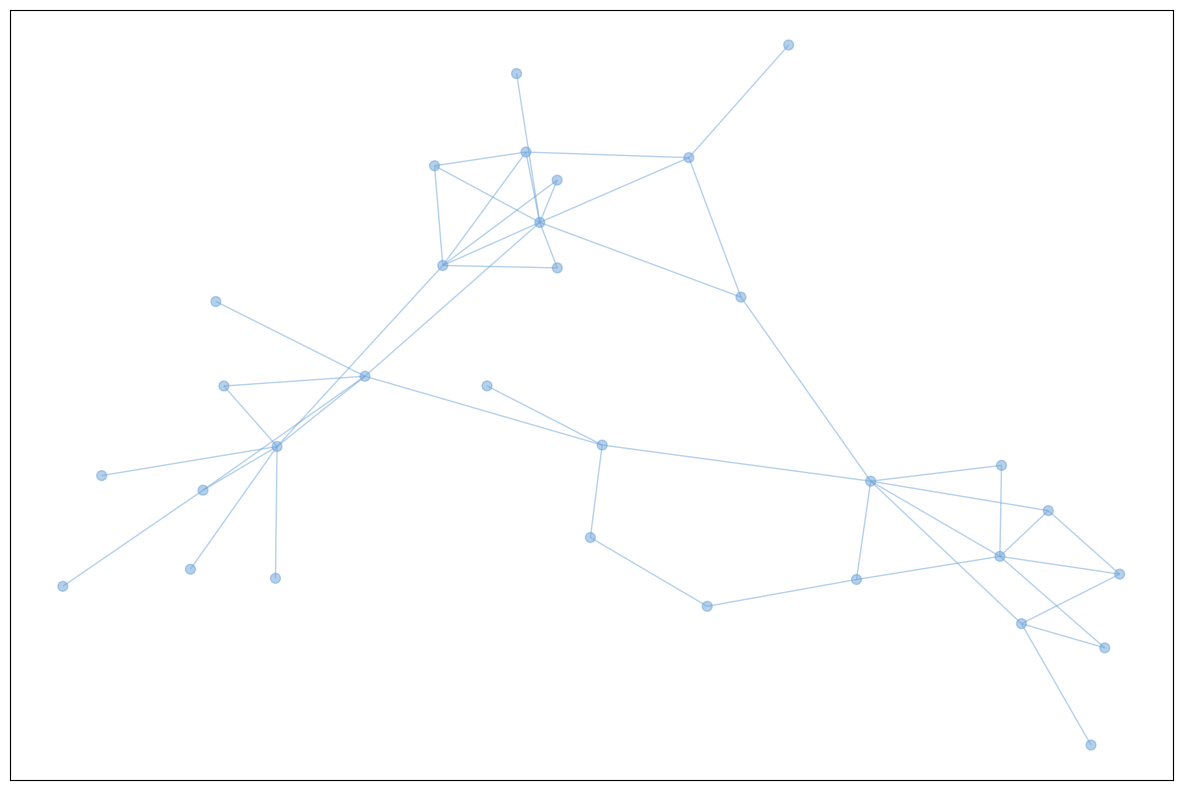

In [159]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

In [160]:
old_permanence, old_permanence_list = calculatePermanence(graph)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 957.99it/s]


Permanence Value  0.2864335317460318


In [161]:
old_safeness, old_safeness_list = calculateSafenessScore(graph, clique_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 1584.61it/s]


Safeness Score  0.45060483870967727


### Pemanence Updation

In [0]:
graph1 = nx.parse_edgelist(edge_data, nodetype = str)
set_node_community(graph1, clique_communities)

In [163]:
new_permanence = max_permanence(graph1)
print("\nNew Permanence Value ", new_permanence)

100%|██████████| 32/32 [00:00<00:00, 432.77it/s]


0.2864335317460318


100%|██████████| 32/32 [00:00<00:00, 462.60it/s]


0.2864335317460318

New Permanence Value  0.2864335317460318


In [0]:
new_clique_communities = getCommunities(graph1,len(clique_communities))

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph1)

In [166]:
new_safeness, new_safeness_list = calculateSafenessScore(graph1, new_clique_communities)
print("\nNew Safeness Score ", new_safeness)

100%|██████████| 32/32 [00:00<00:00, 2315.30it/s]


New Safeness Score  0.45060483870967727


In [167]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  0.0
Safeness Gain 0.0


In [168]:
# Communities Descriptions
print(f"The network has {len(clique_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")

sizes = getCommunitySize(graph1,len(clique_communities))
for i,c in enumerate(clique_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{sizes[i]}\t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 1 communities.

Time taken by algorithm 0:00:00.005430

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		32		49 		 0			 0.099 		 0.290


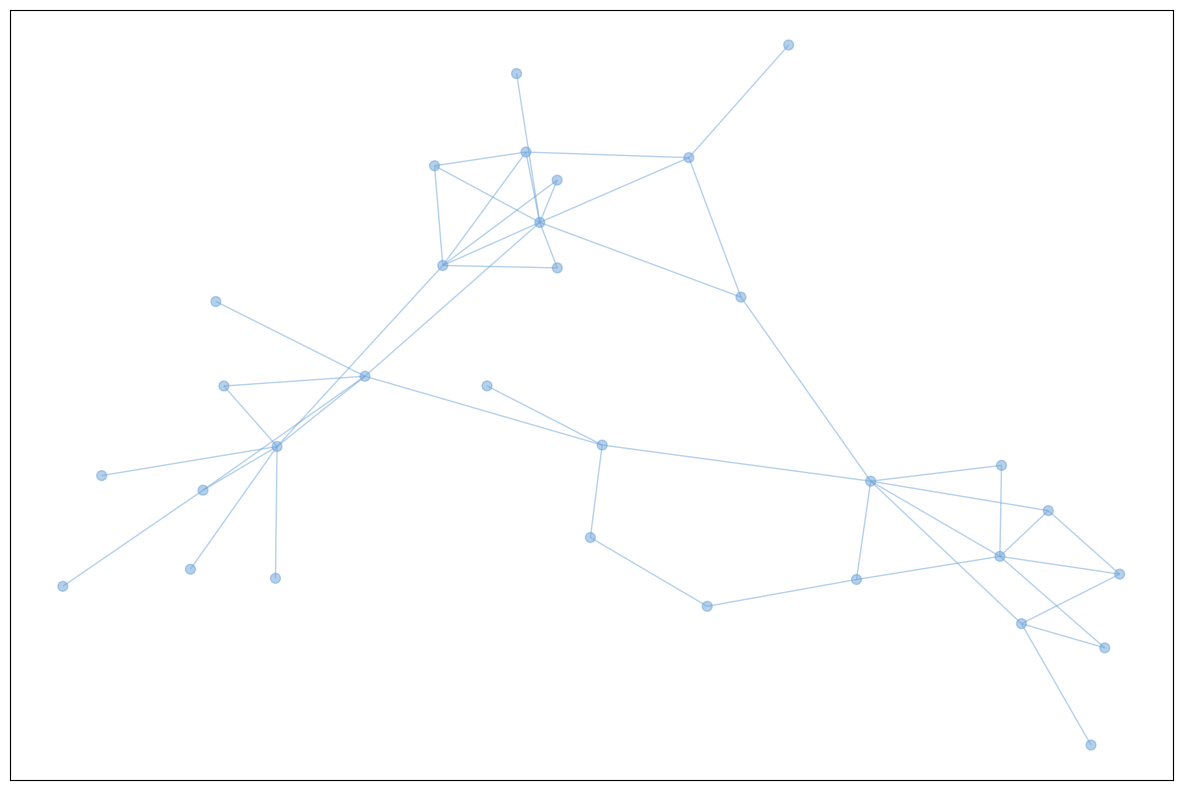

In [169]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] > 0]
# Generate color for each node and egde
node_color = [get_color(graph1.nodes[v]['community']) for v in graph1.nodes]
internal_color = [get_color(graph1.edges[e]['community']) for e in internal]
# Draw Community Graph
nx.draw_networkx(graph1, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph1, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

### Network Rewiring 

In [0]:
graph2 = nx.parse_edgelist(edge_data, nodetype = str)
updated_clique_communities = list(k_clique_communities(graph2, 3))
set_node_community(graph2, updated_clique_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)

In [171]:
old_permanence, old_permanence_list = calculatePermanence(graph2)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1866.05it/s]


Permanence Value  0.011135912698412687


In [172]:
old_safeness, old_safeness_list = calculateSafenessScore(graph2, updated_clique_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 4312.77it/s]


Safeness Score  0.16281001984126983


In [173]:
count = 15
permanence_list = []
safeness_list = []
for p in range(count):
    add_edge(graph2, updated_clique_communities)
    delete_edge(graph2, updated_clique_communities)
    updated_clique_communities = list(k_clique_communities(graph2, 3))
    set_node_community(graph2, updated_clique_communities)
    edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)
    
    new_permanence, new_permanence_list = calculatePermanence(graph2)
    new_safeness, new_safeness_list = calculateSafenessScore(graph2, updated_clique_communities)
    permanence_list.append(new_permanence)
    safeness_list.append(new_safeness)
    print("Edge Update",p+1,"[ Permanence Value:", new_permanence,", Safeness Score :", new_safeness,"]\n")
    time.sleep(0.4)

100%|██████████| 32/32 [00:00<00:00, 9614.45it/s]


Edge Update 1 [ Permanence Value: 0.018576388888888865 , Safeness Score : 0.1576016865079365 ]



100%|██████████| 32/32 [00:00<00:00, 5283.95it/s]


Edge Update 2 [ Permanence Value: 0.07586805555555554 , Safeness Score : 0.15239335317460315 ]



100%|██████████| 32/32 [00:00<00:00, 9262.14it/s]


Edge Update 3 [ Permanence Value: 0.11284722222222224 , Safeness Score : 0.1461433531746032 ]



100%|██████████| 32/32 [00:00<00:00, 6220.41it/s]


Edge Update 4 [ Permanence Value: 0.1582175925925926 , Safeness Score : 0.14475446428571428 ]



100%|██████████| 32/32 [00:00<00:00, 9504.16it/s]


Edge Update 5 [ Permanence Value: 0.2156746031746032 , Safeness Score : 0.1462921626984127 ]



100%|██████████| 32/32 [00:00<00:00, 4668.61it/s]


Edge Update 6 [ Permanence Value: 0.3185267857142857 , Safeness Score : 0.14142485119047618 ]



100%|██████████| 32/32 [00:00<00:00, 8582.79it/s]


Edge Update 7 [ Permanence Value: 0.1693080357142857 , Safeness Score : 0.07799479166666667 ]



100%|██████████| 32/32 [00:00<00:00, 7874.32it/s]


Edge Update 8 [ Permanence Value: 0.00586557539682539 , Safeness Score : 0.048611111111111105 ]



100%|██████████| 32/32 [00:00<00:00, 8141.32it/s]


Edge Update 9 [ Permanence Value: -0.035714285714285726 , Safeness Score : 0.031510416666666666 ]



100%|██████████| 32/32 [00:00<00:00, 14683.05it/s]


Edge Update 10 [ Permanence Value: -0.0716889880952381 , Safeness Score : -0.016183035714285712 ]



100%|██████████| 32/32 [00:00<00:00, 8934.74it/s]


Edge Update 11 [ Permanence Value: -0.04326636904761905 , Safeness Score : -0.005394345238095239 ]



100%|██████████| 32/32 [00:00<00:00, 8376.57it/s]


Edge Update 12 [ Permanence Value: -0.05546875000000001 , Safeness Score : -0.004166666666666664 ]



100%|██████████| 32/32 [00:00<00:00, 7810.62it/s]


Edge Update 13 [ Permanence Value: -0.0031622023809523905 , Safeness Score : 0.04144345238095238 ]



100%|██████████| 32/32 [00:00<00:00, 6697.83it/s]


Edge Update 14 [ Permanence Value: 0.05204613095238095 , Safeness Score : 0.06004464285714285 ]



100%|██████████| 32/32 [00:00<00:00, 7110.12it/s]


Edge Update 15 [ Permanence Value: 0.07366071428571427 , Safeness Score : 0.06631324404761905 ]



In [174]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  0.06252480158730159
Safeness Gain -0.09649677579365078


In [175]:
print(f"The network has {len(updated_clique_communities)} communities.\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(updated_clique_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 1 communities.

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		8 		14 		 5			 0.500 		 1.143


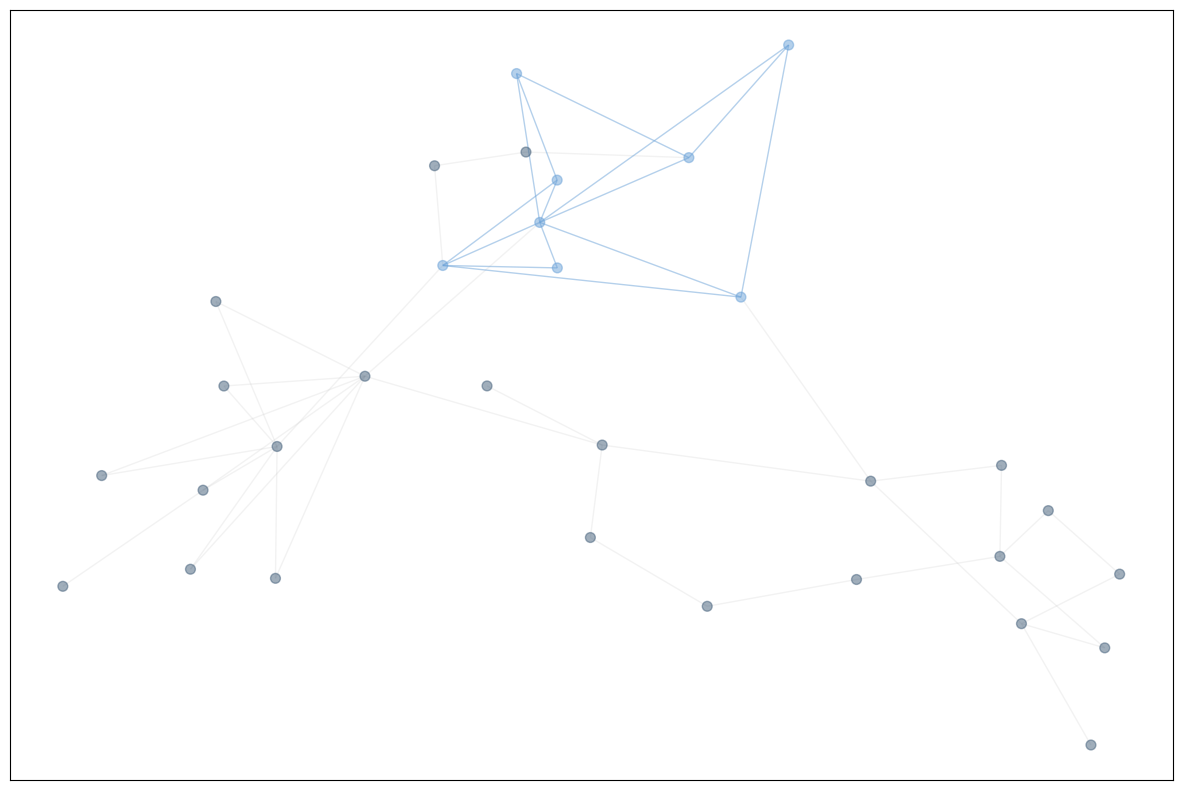

In [176]:
external = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] > 0]
node_color = [get_color(graph2.nodes[v]['community']) for v in graph2.nodes]
internal_color = [get_color(graph2.edges[e]['community']) for e in internal]
nx.draw_networkx(graph2, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph2, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

## Louvain

### Network

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Community Detection using k_clique_communities Algorithm
start_time = datetime.now()
communities = community.best_partition(graph)
end_time = datetime.now()
louvain_communities = [set()]
for i in range(max(communities.values())):
    louvain_communities.append(set())
for i in communities:
    louvain_communities[communities[i]].add(i)


In [0]:
# Set node communities
set_node_community(graph, louvain_communities)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [181]:
# Communities Descriptions
print(f"The network has {len(louvain_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(louvain_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Time taken by algorithm 0:00:00.007968

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			0.356 		 1.000
2 		4 		3 		 3			0.500 		 1.333
3 		9 		14 		 3			0.389 		 0.875
4 		9 		10 		 3			0.278 		 0.875


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

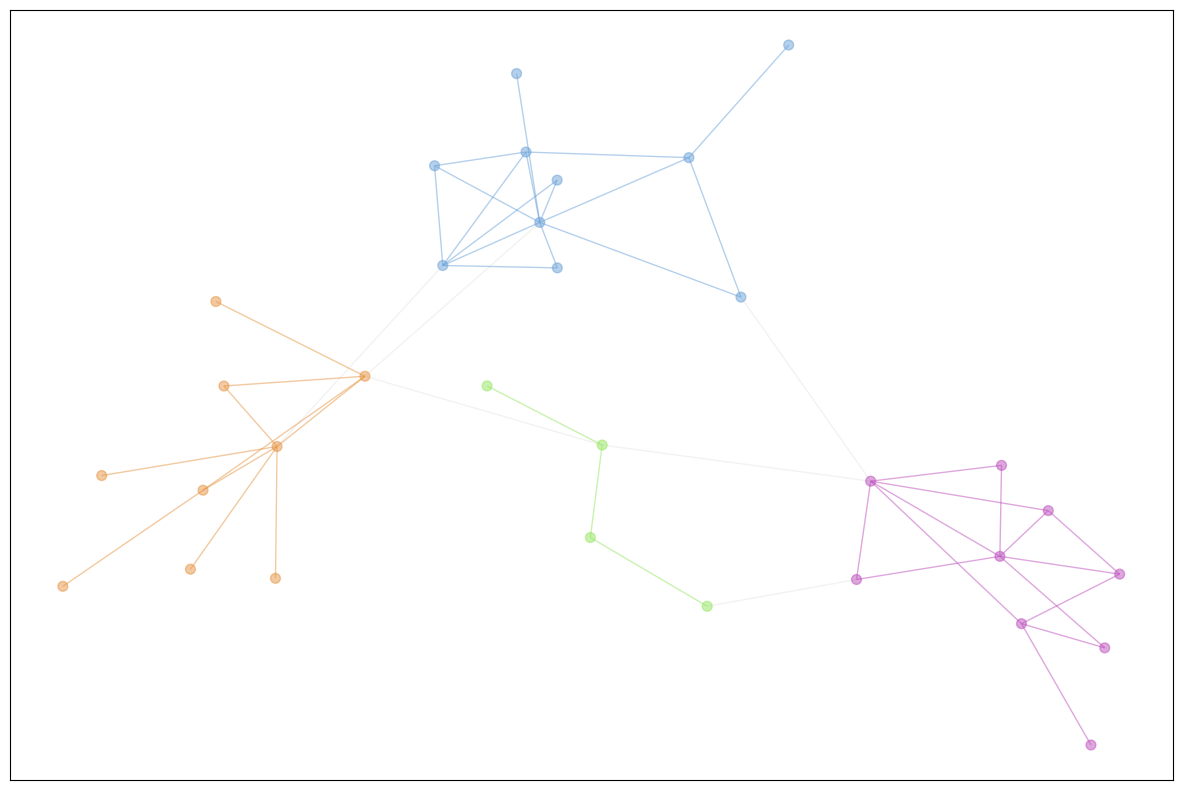

In [184]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

In [185]:
old_permanence, old_permanence_list = calculatePermanence(graph)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1271.75it/s]


Permanence Value  0.2628224206349207


In [186]:
old_safeness, old_safeness_list = calculateSafenessScore(graph, louvain_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 3001.63it/s]


Safeness Score  0.36173115079365087


### Pemanence Updation

In [0]:
graph1 = nx.parse_edgelist(edge_data, nodetype = str)
set_node_community(graph1, louvain_communities)

In [188]:
new_permanence = max_permanence(graph1)
print("\nNew Permanence Value ", new_permanence)

100%|██████████| 32/32 [00:00<00:00, 586.60it/s]


-0.645064484126984


100%|██████████| 32/32 [00:00<00:00, 589.45it/s]


-0.7167162698412698


100%|██████████| 32/32 [00:00<00:00, 512.47it/s]


-0.7167162698412698

New Permanence Value  -0.7167162698412698


In [0]:
new_louvain_communities = getCommunities(graph1,len(louvain_communities))

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph1)

In [191]:
new_safeness, new_safeness_list = calculateSafenessScore(graph1, new_louvain_communities)
print("\nNew Safeness Score ", new_safeness)

100%|██████████| 32/32 [00:00<00:00, 3203.59it/s]


New Safeness Score  0.44595734126984116


In [192]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  -0.9795386904761905
Safeness Gain 0.08422619047619029


In [193]:
# Communities Descriptions
print(f"The network has {len(louvain_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")

sizes = getCommunitySize(graph1,len(louvain_communities))
for i,c in enumerate(louvain_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{sizes[i]}\t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Time taken by algorithm 0:00:00.007968

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10		7 		 18			 0.156 		 0.778
2 		7		5 		 12			 0.833 		 2.333
3 		6		3 		 12			 0.083 		 0.750
4 		9		4 		 18			 0.111 		 1.125


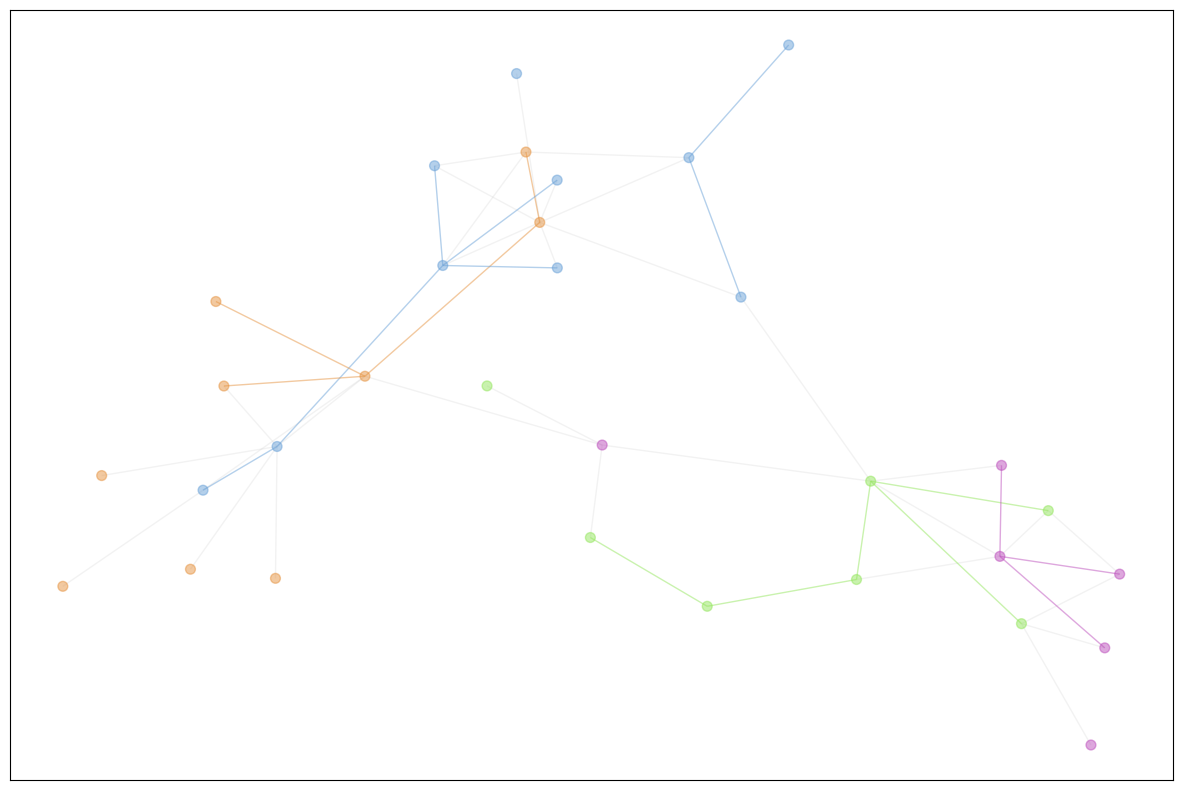

In [194]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph1.edges if graph1.edges[v, w]['community'] > 0]
# Generate color for each node and egde
node_color = [get_color(graph1.nodes[v]['community']) for v in graph1.nodes]
internal_color = [get_color(graph1.edges[e]['community']) for e in internal]
# Draw Community Graph
nx.draw_networkx(graph1, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph1, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

### Network Rewiring 

In [0]:
graph2 = nx.parse_edgelist(edge_data, nodetype = str)
communities = community.best_partition(graph)
updated_louvain_communities = [set()]
for i in range(max(communities.values())):
    updated_louvain_communities.append(set())
for i in communities:
    updated_louvain_communities[communities[i]].add(i)
set_node_community(graph2, updated_louvain_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)

In [196]:
old_permanence, old_permanence_list = calculatePermanence(graph2)
print("\nPermanence Value ", old_permanence)

100%|██████████| 32/32 [00:00<00:00, 1730.84it/s]


Permanence Value  0.2628224206349207


In [197]:
old_safeness, old_safeness_list = calculateSafenessScore(graph2, updated_louvain_communities)
print("\nSafeness Score ", old_safeness)

100%|██████████| 32/32 [00:00<00:00, 2588.93it/s]


Safeness Score  0.36173115079365087


In [198]:
count = 15
permanence_list = []
safeness_list = []
for p in range(count):
    add_edge(graph2, updated_louvain_communities)
    delete_edge(graph2, updated_louvain_communities)
    communities = community.best_partition(graph)
    updated_louvain_communities = [set()]
    for i in range(max(communities.values())):
        updated_louvain_communities.append(set())
    for i in communities:
        updated_louvain_communities[communities[i]].add(i)
    set_node_community(graph2, updated_louvain_communities)
    edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph2)
    
    new_permanence, new_permanence_list = calculatePermanence(graph2)
    new_safeness, new_safeness_list = calculateSafenessScore(graph2, updated_louvain_communities)
    permanence_list.append(new_permanence)
    safeness_list.append(new_safeness)
    print("Edge Update",p+1,"[ Permanence Value:", new_permanence,", Safeness Score :", new_safeness,"]\n")
    time.sleep(0.4)

100%|██████████| 32/32 [00:00<00:00, 4634.43it/s]


Edge Update 1 [ Permanence Value: 0.23464161706349207 , Safeness Score : 0.3501054067460318 ]



100%|██████████| 32/32 [00:00<00:00, 5527.91it/s]


Edge Update 2 [ Permanence Value: 0.20339161706349207 , Safeness Score : 0.33838665674603174 ]



100%|██████████| 32/32 [00:00<00:00, 5399.16it/s]


Edge Update 3 [ Permanence Value: 0.1572420634920635 , Safeness Score : 0.34964037698412703 ]



100%|██████████| 32/32 [00:00<00:00, 4162.56it/s]


Edge Update 4 [ Permanence Value: 0.13692956349206348 , Safeness Score : 0.33792162698412703 ]



100%|██████████| 32/32 [00:00<00:00, 7365.70it/s]


Edge Update 5 [ Permanence Value: 0.08581349206349206 , Safeness Score : 0.35075644841269843 ]



100%|██████████| 32/32 [00:00<00:00, 5729.68it/s]


Edge Update 6 [ Permanence Value: 0.06810515873015871 , Safeness Score : 0.3421626984126984 ]



100%|██████████| 32/32 [00:00<00:00, 7283.36it/s]


Edge Update 7 [ Permanence Value: 0.05091765873015872 , Safeness Score : 0.35283978174603176 ]



100%|██████████| 32/32 [00:00<00:00, 5876.69it/s]


Edge Update 8 [ Permanence Value: 0.03268849206349205 , Safeness Score : 0.36586061507936507 ]



100%|██████████| 32/32 [00:00<00:00, 7808.80it/s]


Edge Update 9 [ Permanence Value: 0.01133432539682537 , Safeness Score : 0.3603918650793651 ]



100%|██████████| 32/32 [00:00<00:00, 6855.19it/s]


Edge Update 10 [ Permanence Value: -0.02225942460317462 , Safeness Score : 0.3679439484126984 ]



100%|██████████| 32/32 [00:00<00:00, 4716.84it/s]


Edge Update 11 [ Permanence Value: -0.03163442460317461 , Safeness Score : 0.37757936507936507 ]



100%|██████████| 32/32 [00:00<00:00, 4679.02it/s]


Edge Update 12 [ Permanence Value: -0.02903025793650794 , Safeness Score : 0.3749751984126984 ]



100%|██████████| 32/32 [00:00<00:00, 8262.60it/s]


Edge Update 13 [ Permanence Value: -0.11236359126984127 , Safeness Score : 0.38408978174603176 ]



100%|██████████| 32/32 [00:00<00:00, 7757.35it/s]


Edge Update 14 [ Permanence Value: -0.14100942460317462 , Safeness Score : 0.38799603174603176 ]



100%|██████████| 32/32 [00:00<00:00, 4801.72it/s]


Edge Update 15 [ Permanence Value: -0.15142609126984127 , Safeness Score : 0.39190228174603176 ]



In [199]:
print("Permanence Loss ",new_permanence - old_permanence)
print("Safeness Gain", new_safeness - old_safeness)

Permanence Loss  -0.414248511904762
Safeness Gain 0.030171130952380887


In [200]:
print(f"The network has {len(updated_louvain_communities)} communities.\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(updated_louvain_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			 0.356 		 1.000
2 		4 		1 		 18			 0.167 		 3.000
3 		9 		1 		 18			 0.028 		 0.625
4 		9 		10 		 3			 0.278 		 0.875


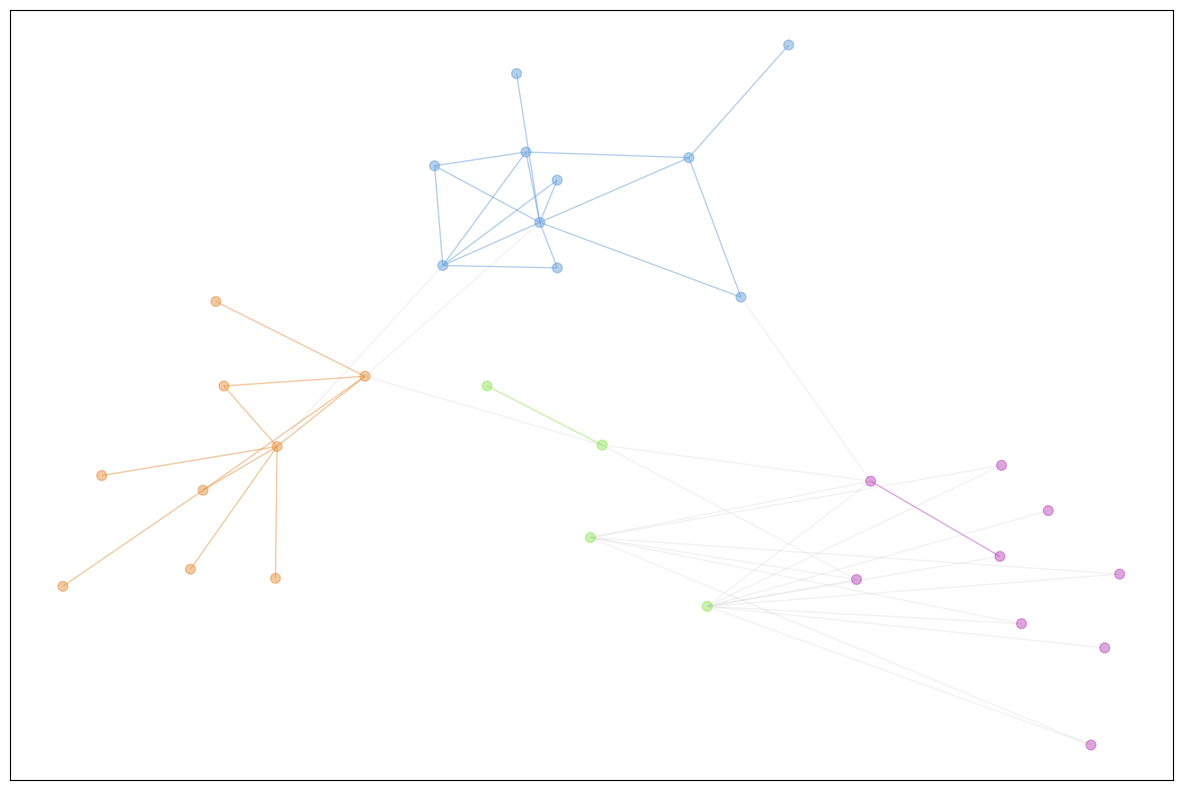

In [201]:
external = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph2.edges if graph2.edges[v, w]['community'] > 0]
node_color = [get_color(graph2.nodes[v]['community']) for v in graph2.nodes]
internal_color = [get_color(graph2.edges[e]['community']) for e in internal]
nx.draw_networkx(graph2, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph2, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

# Constant community

## Community

In [0]:
def constant_communuty(*communities):
    if len(communities)>1:
        community = communities[0]
        for k in communities[1:]:
            ls = []
            for i in community:
                for j in k:
                    a = i.intersection(j)
                    if len(a)>3:
                        ls.append(a)
            community = ls
        return community
    return communities

In [0]:
ls1 = constant_communuty(greedy_communities, label_communities, girvan_communities, lpa_communities, bisection_communities, louvain_communities)

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Set node communities
set_node_community(graph, ls1)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [207]:
# Communities Descriptions
print(f"The network has {len(ls1)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(ls1):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 3 communities.

Time taken by algorithm 0:00:00.007968

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			0.356 		 1.000
2 		6 		9 		 6			0.600 		 1.400
3 		6 		5 		 4			0.333 		 1.400


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

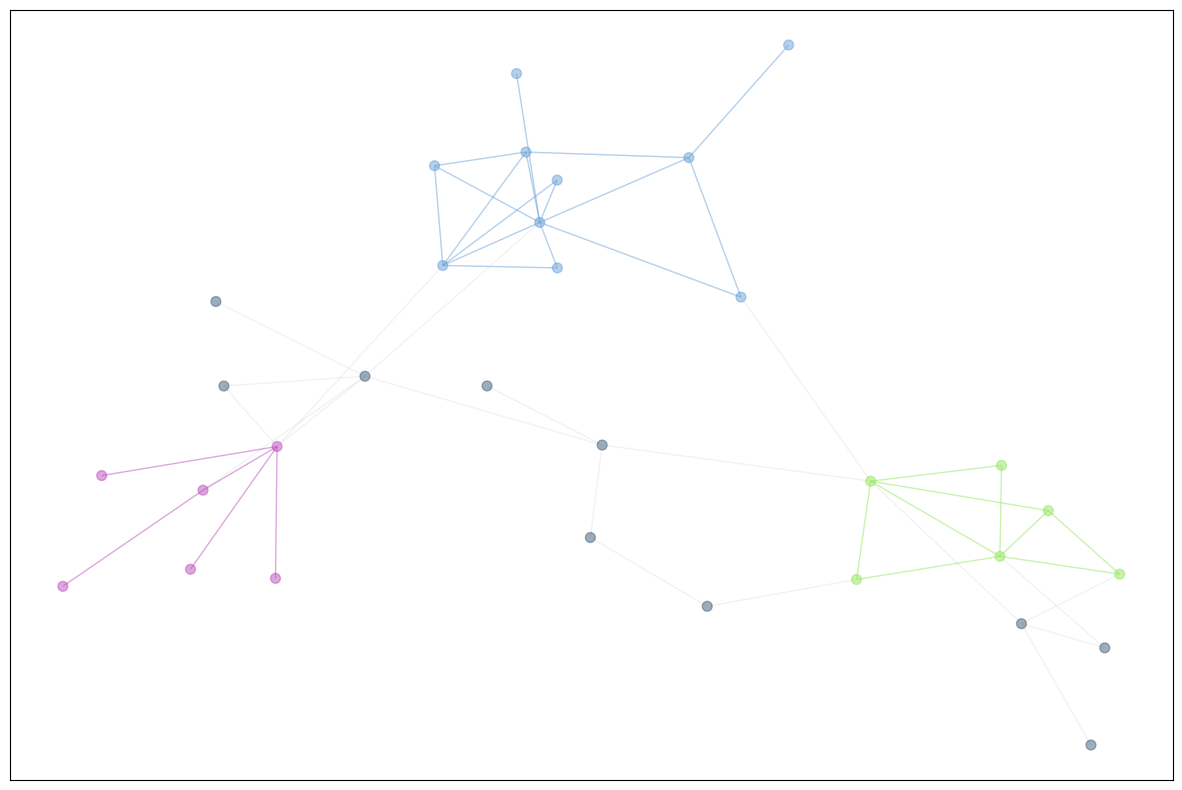

In [210]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

In [211]:
## Constant density
num = 0
for i in ls1:
  num+=len(i)
print("Number of nodes in constant community ",num)
print("Toatal number of nodes ",len(list(graph.nodes())))
print("Constant percentage", num/len(list(graph.nodes())))

Number of nodes in constant community  22
Toatal number of nodes  32
Constant percentage 0.6875


## After Minimisation of Permanence 

In [0]:
ls2 = constant_communuty(new_greedy_communities, new_label_communities, new_girvan_communities, new_lpa_communities, new_bisection_communities, new_louvain_communities)

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Set node communities
set_node_community(graph, ls2)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [216]:
# Communities Descriptions
print(f"The network has {len(ls2)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(ls2):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Time taken by algorithm 0:00:00.007968

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		6 		2 		 9			0.133 		 0.800
2 		4 		3 		 13			0.500 		 2.333
3 		5 		4 		 14			0.400 		 2.250
4 		4 		0 		 4			0.000 		 0.333


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

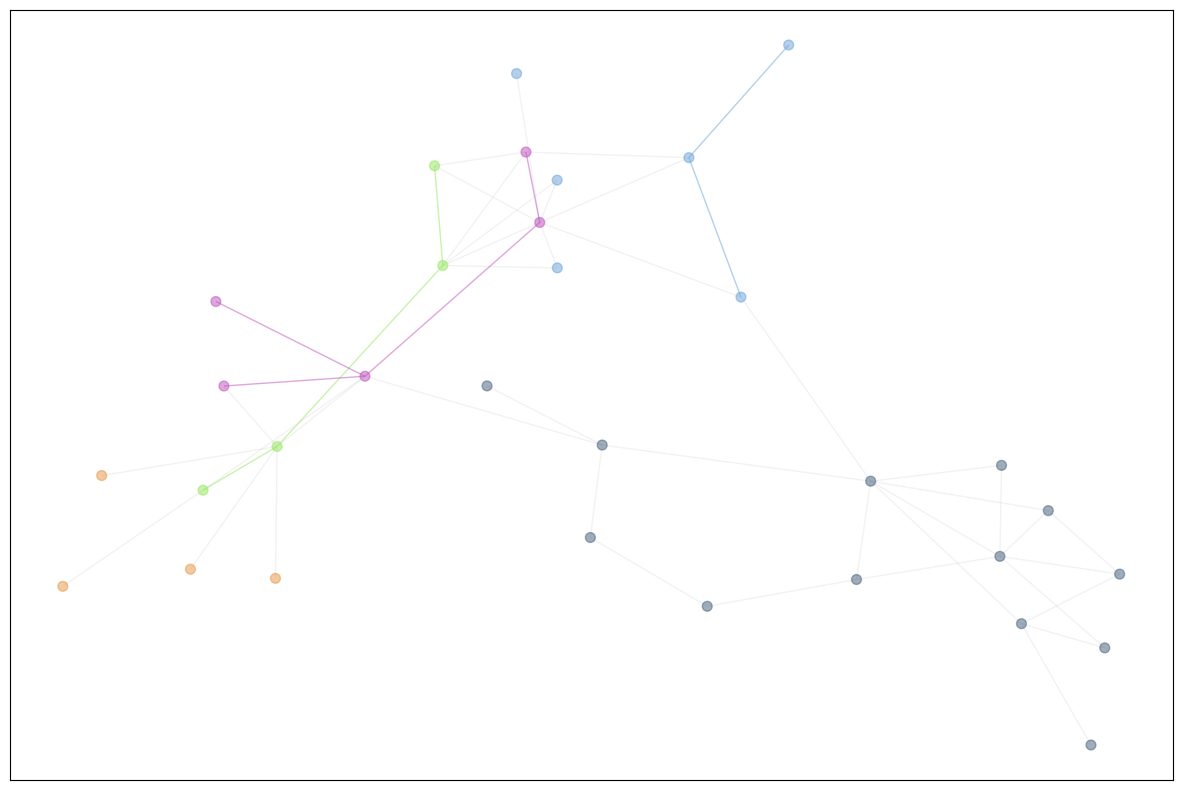

In [219]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

In [220]:
## Constant density
num = 0
for i in ls2:
  num+=len(i)
print("Number of nodes in constant community ",num)
print("Toatal number of nodes ",len(list(graph.nodes())))
print("Constant percentage", num/len(list(graph.nodes())))

Number of nodes in constant community  19
Toatal number of nodes  32
Constant percentage 0.59375


## After use rewiring of network for Minimisation of Permanence 

In [0]:
ls3 = constant_communuty(updated_greedy_communities, updated_label_communities, updated_girvan_communities, updated_lpa_communities, updated_bisection_communities, updated_louvain_communities)

In [0]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [0]:
# Set node communities
set_node_community(graph, ls3)

In [0]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [225]:
# Communities Descriptions
print(f"The network has {len(ls3)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(ls3):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1) if len(c)>1 else 0
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 2 communities.

Time taken by algorithm 0:00:00.007968

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		7 		10 		 6			0.476 		 1.167
2 		9 		14 		 4			0.389 		 1.125


In [0]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [0]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

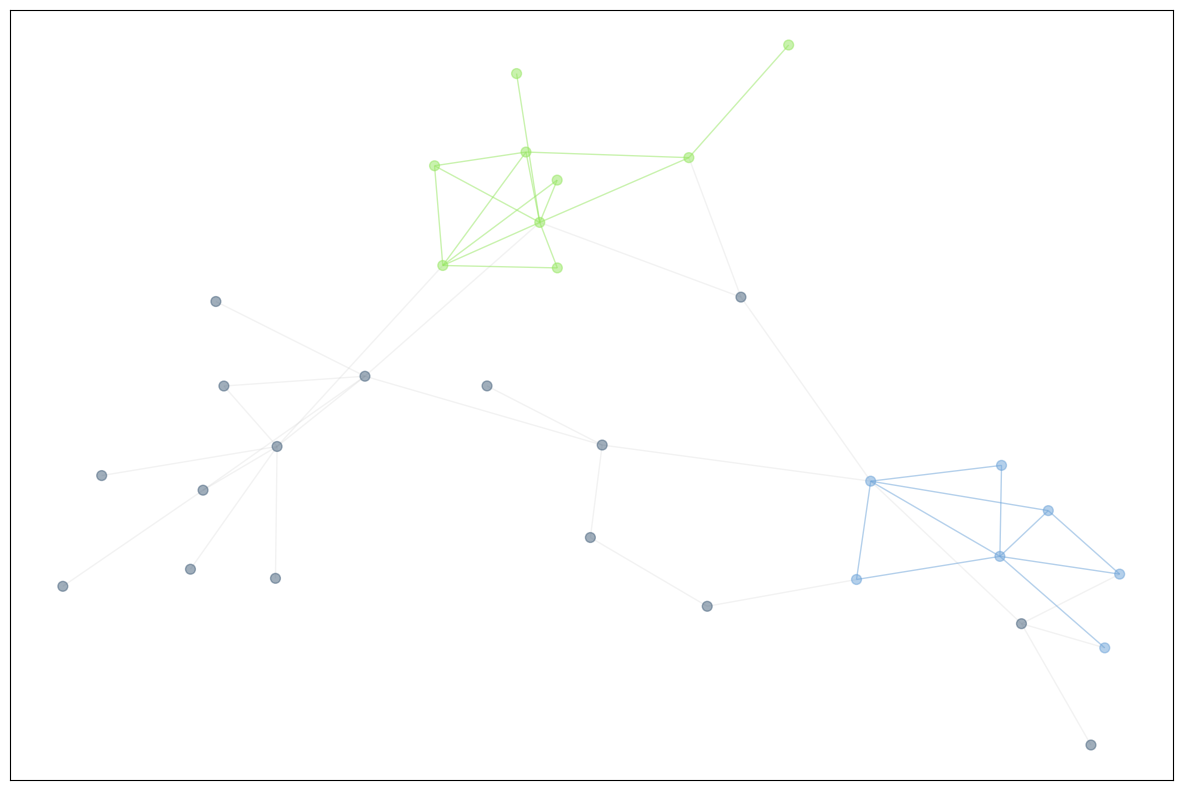

In [228]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=False)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=False)
plt.show()

In [229]:
## Constant density
num = 0
for i in ls3:
  num+=len(i)
print("Number of nodes in constant community ",num)
print("Toatal number of nodes ",len(list(graph.nodes())))
print("Constant percentage", num/len(list(graph.nodes())))

Number of nodes in constant community  16
Toatal number of nodes  32
Constant percentage 0.5
